In [1]:
import pandas as pd
import numpy as np
import re
import emoji
import nltk
from bs4 import BeautifulSoup
from matplotlib import pyplot as plt
from gensim.corpora import Dictionary
from gensim.models.ldamulticore import LdaMulticore
from gensim.models.coherencemodel import CoherenceModel
import pyLDAvis.gensim_models
from nltk.corpus import stopwords
from nltk.tokenize import TweetTokenizer
from nltk.stem import WordNetLemmatizer
from HanTa import HanoverTagger as ht
%matplotlib inline

nltk.download('wordnet')
nltk.download("stopwords")
import warnings
warnings.filterwarnings('ignore')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Admin\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Admin\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Topic Modelling

For topic modelling the same data set as for the sentiment analysis is used, which means that tweets not directly containing the hashtag, as well as retweets are removed. 

In [2]:
df = pd.read_csv ('data/tweets/IchBinHanna.csv')
df= df[['author.description', 'author.id', 'author.name', 'author.public_metrics.followers_count', 'author.public_metrics.following_count', 'author.username', 'author_id', 'created_at', 'id', 'lang', 'public_metrics.retweet_count','text', 'hashtags','reference_type','wanted_tag']]
#add user profiles
user_profiles = pd.read_csv('data/tweets/TwitterUserClassification.csv')
user_merge = user_profiles[['author.id', 'user.group']]
df = df.merge(user_merge)

In [3]:
#get the correct data
df['new_date'] = pd.to_datetime(df['created_at']).dt.strftime('%Y-%m-%d %H:%M:%S')
df = df.loc[(df['new_date'] > '2021-06-01 00:00:00') & (df['new_date'] <= '2021-09-30 23:59:59')]
df = df.loc[df['reference_type'] != 'retweeted']
df = df[df['text'].str.contains("#ichbinhanna", case = False)]
df['processed'] = df['text'].astype(str)
df['processed'] = df['processed'].replace(r'\\n',  ' ', regex=True)
df = df.loc[(df['lang'] == 'de') | (df['lang'] == 'en')]

In [4]:
#clean the data (remove URLs, emojis and line breaks)
pat1 = r'http[s]?://(?:[a-z]|[0-9]|[$-_@.&amp;+]|[!*\(\),]|(?:%[0-9a-f][0-9a-f]))+'
pat2 = r'www.[^ ]+'
combined_pat = r'|'.join((pat1, pat2))
split_pattern = re.compile(r'\b('  + r')\b')
def tweet_cleaner(demo):
    soup = BeautifulSoup(demo, 'lxml') # HTML
    souped = soup.get_text()
    stripped = re.sub(combined_pat, '', souped)
    return stripped
df['processed'] = [tweet_cleaner(t) for t in df['processed']]
def rem_emojis(text):
    emojis = [x for x in text if x in emoji.UNICODE_EMOJI]
    cleaned = ' '.join([str for str in text.split() if not any(i in str for i in emojis)])
    return cleaned
df['processed'] = df['processed'].apply(lambda x: rem_emojis(x))
df['processed'] = df['processed'].astype(str)

In [5]:
#preprocessing (tokenization, stop word removal, lemmatizing)
german_stop = set(stopwords.words('german'))
english_stop = set(stopwords.words('english'))
add_stop_all = ["ichbinhanna","#ichbinhanna", "hanna", "mehr", "innen", "#wisszeitvg", "#ichbinhannah", "@amreibahr", "amreibahr", "@bmf_bund","bmf_bund", "@drkeichhorn", "drkeichhorn", "@sebastiankubon", "sebastiankubon", "@bmbf_bund", "mehr", "innen", "schon", "gehen", "jahr","wissenschaft", "wissenschaftler", "kommen","academia", "academic", "year", "machen", "sagen", "sein","geben", "also", "werden", "german", "germany","gut", "haben", "geht", "gibt", "viele", "seit", "wäre", "sehen", "ganz","bekommen"]
german_stop.update(set(add_stop_all))
english_stop.update(set(add_stop_all))
tweet_tokenizer = TweetTokenizer()
df['tokenized'] = df['processed'].apply(lambda x: tweet_tokenizer.tokenize(x.lower()))
#remove all words consisting of 3 characters or less to shorten the dictionary of unique words
df['tokenized'] = df[['tokenized','lang']].apply(lambda x: ' '.join([word for word in x['tokenized'] if word not in english_stop]).split() if x['lang'] == 'en' else ' '.join([word for word in x['tokenized'] if word not in german_stop]).split(),axis=1)
df['tokenized'] = df['tokenized'].apply(lambda x: [word for word in x if len(word) > 3])
lemmatizer = WordNetLemmatizer()
hannover = ht.HanoverTagger('morphmodel_ger.pgz')
df['lemmatized'] = df[['tokenized','lang']].apply(lambda x: [lemmatizer.lemmatize(word).lower() for word in x['tokenized']] if x['lang'] == 'en' else [hannover.analyze(word)[0].lower() for word in x['tokenized']] ,axis=1)

In [6]:
def perform_LDA(tokens, topics=5, passes =5, alpha = 'symmetric', decay = 0.5):
    #create the dictionary of lemmatized tokens
    dic = Dictionary(tokens)
    print(len(dic))
    #remove low and high frequent terms
    dic.filter_extremes(no_below=2, no_above=.99)
    print(len(dic))
    #create the bag of words 
    corpus = [dic.doc2bow(d) for d in tokens]
    #build LDA model 
    LDA = LdaMulticore(corpus= corpus, num_topics=topics, id2word= dic, workers=12, passes=passes, alpha = alpha, decay = decay)
    words = [re.findall(r'"([^"]*)"',t[1]) for t in LDA.print_topics()]
    #create topics
    topics = [' '.join(t[0:10]) for t in words]

    for id, t in enumerate(topics): 
        print(f"------ Topic {id} ------")
        print(t, end="\n\n")
    # Compute Perplexity
    perplexity = LDA.log_perplexity(corpus)
    print('\nPerplexity: ', perplexity) 
    # Compute Coherence Score
    coherence_model = CoherenceModel(model=LDA, texts=tokens, 
                                   dictionary=dic, coherence='c_v')
    coherence_lda_model = coherence_model.get_coherence()
    print('\nCoherence Score: ', coherence_lda_model)
    return LDA

In [7]:
#perform topic modelling by applying LDA on the whole data set, and on the german/english only sets (guided by: https://towardsdatascience.com/twitter-topic-modeling-e0e3315b12e2)
#full data set
full_model = perform_LDA(df['tokenized'])

44921
18922
------ Topic 0 ------
@anjakarliczek #ichbinreyhan danke einfach immer heute lehre jahren #hannaimbundestag stellen

------ Topic 1 ------
thread heute #hannaimbundestag arbeit jahre hashtag jahren system hochschulen problem

------ Topic 2 ------
forschung jahre zeit deutschland arbeitsbedingungen lehre @anjakarliczek immer promotion hochschulen

------ Topic 3 ------
system @gew_bund #dauerstellen immer letzten hashtag #hannaimbundestag zeit arbeit research

------ Topic 4 ------
jahren jahre stelle @anjakarliczek system stellen #ichbinreyhan eigentlich warum forschung


Perplexity:  -9.147897980669791

Coherence Score:  0.18044494256778065


In [8]:
#only german tweets
df_ger = df.loc[df['lang'] == "de"]
df_en = df.loc[df['lang'] == "en"]
ger_model = perform_LDA(df_ger['tokenized'])

38733
15845
------ Topic 0 ------
jahre system forschung stelle stellen jahren promotion befristet gute thema

------ Topic 1 ------
warum thread einfach gerade dafür forschung wirklich wurde @anjakarliczek immer

------ Topic 2 ------
#hannaimbundestag hochschulen @anjakarliczek immer jahre arbeitsbedingungen #ichbinreyhan einfach stellen jahren

------ Topic 3 ------
arbeit immer @gew_bund zeit problem #ichbinreyhan unis heute #dauerstellen gerade

------ Topic 4 ------
@anjakarliczek lehre forschung danke jahre letzten #ichbinreyhan stellen #hannaimbundestag deutschland


Perplexity:  -8.966440877707218

Coherence Score:  0.11875542851134704


In [9]:
#only english tweets
en_model = perform_LDA(df_en['tokenized'])

8194
3579
------ Topic 0 ------
system research precarious people permanent contract years much working hashtag

------ Topic 1 ------
#ichbinreyhan working conditions system important thread career researchers english work

------ Topic 2 ------
science researchers research career contracts system work time people young

------ Topic 3 ------
many like academics @mahaelhissy time contracts years research working system

------ Topic 4 ------
thread years work want contracts permanent scholars contract story good


Perplexity:  -7.933724370254112

Coherence Score:  0.23273975941200215


In [10]:
#get topics by month
df_june = df.loc[(df['new_date'] > '2021-06-01 00:00:00') & (df['new_date'] <= '2021-06-30 23:59:59')]
df_july = df.loc[(df['new_date'] > '2021-07-01 00:00:00') & (df['new_date'] <= '2021-07-31 23:59:59')]
df_august = df.loc[(df['new_date'] > '2021-08-01 00:00:00') & (df['new_date'] <= '2021-08-31 23:59:59')]
df_september = df.loc[(df['new_date'] > '2021-09-01 00:00:00') & (df['new_date'] <= '2021-09-30 23:59:59')]

In [11]:
#tweets from june
june_model = perform_LDA(df_june['tokenized'])

30966
12697
------ Topic 0 ------
forschung heute lehre jahren immer einfach #hannaimbundestag @anjakarliczek jahre danke

------ Topic 1 ------
#hannaimbundestag jahre @anjakarliczek system thread bitte gerade unis hochschulen müssen

------ Topic 2 ------
system jahre gerade jahren warum #hannaimbundestag promotion stelle eigentlich wisszeitvg

------ Topic 3 ------
immer system stellen #hannaimbundestag @anjakarliczek arbeitsbedingungen hochschulen geld lehre menschen

------ Topic 4 ------
@anjakarliczek #hannaimbundestag hashtag zeit forschung jahre letzten jahren stelle system


Perplexity:  -8.950756134374894

Coherence Score:  0.22677658219665964


In [12]:
#tweets from july
july_model = perform_LDA(df_july['tokenized'])

17109
6765
------ Topic 0 ------
immer #ichbinreyhan stellen stelle befristete heute dauerstellen @gew_bund hochschulen genug

------ Topic 1 ------
@anjakarliczek gerade immer #ichbinreyhan frage müssen zeit frau work deutschland

------ Topic 2 ------
system @tagesthemen jahre #ichbinreyhan befristet thema kommt @anjakarliczek kommentar arbeit

------ Topic 3 ------
forschung lehre unis zeit jahren deutschland immer nachwuchs problem müssen

------ Topic 4 ------
#ichbinreyhan @gew_bund gerade #hannabeidergew danke #frististfrust system arbeitsbedingungen einfach #dauerstellen


Perplexity:  -8.715508540141167

Coherence Score:  0.344043553930341


In [13]:
#tweets from august
august_model = perform_LDA(df_august['tokenized'])

10381
3652
------ Topic 0 ------
zeit stellen @anjakarliczek gute forschung #ichbinreyhan #wissenschaft frage statt promotion

------ Topic 1 ------
#ichbinreyhan gerade @anjakarliczek @heutejournal danke dank system @mahaelhissy @christine_blume dafür

------ Topic 2 ------
lehre #ichbinreyhan forschung menschen system frage deutschen @karolinedoering thema hochschulen

------ Topic 3 ------
#ichbinreyhan #dauerstellen @gew_bund #waspostdocswollen heute arbeiten promotion einfach problem #frististfrust

------ Topic 4 ------
immer eigentlich system #ichbinreyhan @anjakarliczek beitrag arbeit zeit aktuellen @karolinedoering


Perplexity:  -8.31010062456587

Coherence Score:  0.3904108594082776


In [14]:
#tweets from september
september_model = perform_LDA(df_september['tokenized'])

9759
3395
------ Topic 0 ------
#ichbinreyhan hochschulen stellen forschung postdocs #entfristethanna vertrag jahre system jahren

------ Topic 1 ------
heute @gew_bund #berlhg berliner neue berlin danke macht gute stellen

------ Topic 2 ------
eigentlich @gew_bund #dauerstellen arbeit #wissenschaft unis @nga_wiss forschung arbeitsbedingungen lehre

------ Topic 3 ------
#ichbinreyhan @gew_bund @andreasbovensc1 #hannainzahlen #entfristethanna @swh_hb 2021 @spdlandbremen @janinabruenjes #btw21

------ Topic 4 ------
#ichbinreyhan system monate immer jahren @gew_bund #hannainzahlen #frististfrust aktuellen lehre


Perplexity:  -8.274755470118318

Coherence Score:  0.37719293773620566


In [15]:
def visualize_topics(tokens):
    #Visualization of topic distance 
    vis_dic = Dictionary(tokens)
    vis_dic.filter_extremes(no_below=2, no_above=.99)
    #create the bag of words 
    vis_corpus = [vis_dic.doc2bow(d) for d in tokens]
    #build LDA model a 
    vis_LDA = LdaMulticore(corpus= vis_corpus, num_topics=5, id2word= vis_dic, workers=12, passes=5, random_state = 1)
    pyLDAvis.enable_notebook()
    return pyLDAvis.gensim_models.prepare(vis_LDA, vis_corpus, vis_dic)
def visualize_model(model, tokens):
    vis_dic = Dictionary(tokens)
    vis_dic.filter_extremes(no_below=2, no_above=.99)
    vis_corpus = [vis_dic.doc2bow(d) for d in tokens]
    pyLDAvis.enable_notebook()
    return pyLDAvis.gensim_models.prepare(model, vis_corpus, vis_dic)

In [16]:
visualize_topics(df['tokenized'])

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0      0.051749  0.010243       1        1  22.431090
4      0.032309  0.045429       2        1  21.519991
1      0.024205  0.014771       3        1  20.092897
3     -0.117080  0.013776       4        1  18.441420
2      0.008816 -0.084219       5        1  17.514603, topic_info=            Term        Freq       Total Category  logprob  loglift
65        thread  397.000000  397.000000  Default  30.0000  30.0000
145      working  144.000000  144.000000  Default  29.0000  29.0000
130   conditions  133.000000  133.000000  Default  28.0000  28.0000
139   precarious  131.000000  131.000000  Default  27.0000  27.0000
2992    verträge  224.000000  224.000000  Default  26.0000  26.0000
...          ...         ...         ...      ...      ...      ...
893         zeit   85.570009  509.030850   Topic5  -6.1137  -0.0410
1594       jahre   88.441466  669.807711   Topic5  -6.0807  -0.2825
1032   forschung   88.783610  696.045646   Topic5  -6.0768  -0.3171
404        heute   80.378391  513.116789   Topic5  -6.1763  -0.1116
2587       dafür   68.465762  341.050800   Topic5  -6.3367   0.1364

[461 rows x 6 columns], token_table=      Topic      Freq                      Term
term                                           
1566      1  0.320478           #95vswisszeitvg
1566      2  0.243697           #95vswisszeitvg
1566      3  0.153562           #95vswisszeitvg
1566      4  0.143547           #95vswisszeitvg
1566      5  0.136871           #95vswisszeitvg
...     ...       ...                       ...
4062      4  0.860262          ️arbeitsverträge
4063      4  0.906502                     ️ende
4064      4  0.849637  ️erwerbsarbeitslosigkeit
4064      5  0.106205  ️erwerbsarbeitslosigkeit
4066      4  0.894803               ️stipendium

[1157 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 5, 2, 4, 3])

In [17]:
def create_dic_corpus(tokens):
    dic = Dictionary(tokens)
    dic.filter_extremes(no_below=2, no_above=.99)
    corpus = [dic.doc2bow(d) for d in tokens]
    return dic, corpus
#get optimal number of topics for each (sub)set
def compute_coherence_values_topics(tokens, limit=10, start=2, step=1):
    dic, corpus = create_dic_corpus(tokens)
    coherence_values_topic = []
    model_list_topic = []
    for num_topics in range(start, limit, step):
        model = LdaMulticore(corpus=corpus, num_topics=num_topics, id2word=dic, random_state = 1)
        model_list_topic.append(num_topics)
        coherencemodel = CoherenceModel(model=model, texts=tokens, dictionary=dic, coherence='c_v')
        coherence_values_topic.append(coherencemodel.get_coherence())

    print(model_list_topic, coherence_values_topic)
    
def compute_coherence_values_passes(tokens,num_topics):
    
    passes = [5,10,15,20]
    dic, corpus = create_dic_corpus(tokens)
    coherence_values_passes = []
    model_list_passes = []
    for num_pass in passes:
        model = LdaMulticore(corpus=corpus, num_topics=num_topics, id2word=dic, passes = num_pass, random_state = 1)
        model_list_passes.append(num_pass)
        coherencemodel = CoherenceModel(model=model, texts=tokens, dictionary=dic, coherence='c_v')
        coherence_values_passes.append(coherencemodel.get_coherence())

    print(model_list_passes, coherence_values_passes)
    
def compute_coherence_values_alpha(tokens,num_topics, passes):
    
    alpha = ['symmetric','asymmetric']
    dic, corpus = create_dic_corpus(tokens)
    coherence_values_alpha = []
    model_list_alpha = []
    for a in alpha:
        model = LdaMulticore(corpus=corpus, num_topics=num_topics, id2word=dic, passes = passes, alpha = a, random_state = 1)
        model_list_alpha.append(a)
        coherencemodel = CoherenceModel(model=model, texts=tokens, dictionary=dic, coherence='c_v')
        coherence_values_alpha.append(coherencemodel.get_coherence())

    print(model_list_alpha, coherence_values_alpha)
    
def compute_coherence_values_decay(tokens,num_topics, passes, alpha):
    
    decay = [0.5,0.7,0.9]
    dic, corpus = create_dic_corpus(tokens)
    coherence_values_decay = []
    model_list_decay = []
    for d in decay:
        model = LdaMulticore(corpus=corpus, num_topics=num_topics, id2word=dic, passes = passes, alpha = alpha, random_state = 1, decay =d)
        model_list_decay.append(d)
        coherencemodel = CoherenceModel(model=model, texts=tokens, dictionary=dic, coherence='c_v')
        coherence_values_decay.append(coherencemodel.get_coherence())

    print(model_list_decay, coherence_values_decay)

In [18]:
#full data
compute_coherence_values_topics(df['tokenized'])
#english data
compute_coherence_values_topics(df_en['tokenized'])
#german data
compute_coherence_values_topics(df_ger['tokenized'])
#june data
compute_coherence_values_topics(df_june['tokenized'])
#july data
compute_coherence_values_topics(df_july['tokenized'])
#august data
compute_coherence_values_topics(df_august['tokenized'])
#september data
compute_coherence_values_topics(df_september['tokenized'])

[2, 3, 4, 5, 6, 7, 8, 9] [0.19565819492792652, 0.15038815174472273, 0.143887655400207, 0.13401912120688317, 0.12206409567494043, 0.1356541195906704, 0.1465594882197138, 0.1331077703072186]
[2, 3, 4, 5, 6, 7, 8, 9] [0.16829818332006824, 0.18510629982149687, 0.21531238762741142, 0.21466465450485997, 0.21295185257723048, 0.23625169600625476, 0.20873232020457813, 0.20357687717860465]
[2, 3, 4, 5, 6, 7, 8, 9] [0.16525170809184547, 0.14017191153954855, 0.10457752706456289, 0.11265916965329739, 0.10616071026535678, 0.1395026115850768, 0.11546165722808399, 0.15355749895803858]
[2, 3, 4, 5, 6, 7, 8, 9] [0.23400425560349514, 0.21120466659816384, 0.1989605263349305, 0.2052123303730473, 0.1940137481172983, 0.19820452611951295, 0.19751999163765305, 0.20146315718431612]
[2, 3, 4, 5, 6, 7, 8, 9] [0.29053335086654536, 0.28954635034916626, 0.33722693955468375, 0.30742030361570816, 0.27785491499129683, 0.31364651674194566, 0.31774032866988733, 0.2890693631154039]
[2, 3, 4, 5, 6, 7, 8, 9] [0.416706118213

In [19]:
#full data
compute_coherence_values_passes(df['tokenized'], 6)
#english data
compute_coherence_values_passes(df_en['tokenized'],7)
#german data
compute_coherence_values_passes(df_ger['tokenized'],8)
#june data
compute_coherence_values_passes(df_june['tokenized'],7)
#july data
compute_coherence_values_passes(df_july['tokenized'],7)
#august data
compute_coherence_values_passes(df_august['tokenized'],7)
#september data
compute_coherence_values_passes(df_september['tokenized'],6)

[5, 10, 15, 20] [0.1722067503248418, 0.24184278155153574, 0.2580311217998921, 0.2616611068202879]
[5, 10, 15, 20] [0.24264447874996745, 0.24546032105022406, 0.24663487127268596, 0.25357773731529903]
[5, 10, 15, 20] [0.14801526229368556, 0.14618912668634637, 0.16136608788271245, 0.1677410133470536]
[5, 10, 15, 20] [0.20594462743516087, 0.2678568656832296, 0.27872610955465843, 0.3070439364894954]
[5, 10, 15, 20] [0.34722107191132645, 0.34742389356329223, 0.3712423895968481, 0.3668242145638977]
[5, 10, 15, 20] [0.3909791717409784, 0.3870335998674581, 0.39158833196515014, 0.3859871949261516]
[5, 10, 15, 20] [0.4172408552315761, 0.4181652809613547, 0.4231244926000281, 0.4326712384977254]


In [20]:
#full data
compute_coherence_values_alpha(df['tokenized'], 6,20)
#english data
compute_coherence_values_alpha(df_en['tokenized'],7,20)
#german data
compute_coherence_values_alpha(df_ger['tokenized'],8,20)
#june data
compute_coherence_values_alpha(df_june['tokenized'],7,20)
#july data
compute_coherence_values_alpha(df_july['tokenized'],7,15)
#august data
compute_coherence_values_alpha(df_august['tokenized'],7,20)
#september data
compute_coherence_values_alpha(df_september['tokenized'],6,20)

['symmetric', 'asymmetric'] [0.2614028882785056, 0.26974079486205055]
['symmetric', 'asymmetric'] [0.25357773731529903, 0.29955988662172184]
['symmetric', 'asymmetric'] [0.16559712639876303, 0.16676518977532404]
['symmetric', 'asymmetric'] [0.3070439364894954, 0.3325118156855216]
['symmetric', 'asymmetric'] [0.3712423895968481, 0.39365934688966153]
['symmetric', 'asymmetric'] [0.3859871949261516, 0.4399801259662578]
['symmetric', 'asymmetric'] [0.4326712384977254, 0.46733394403186596]


In [21]:
#full data
compute_coherence_values_decay(df['tokenized'], 6,20,'asymmetric')
#english data
compute_coherence_values_decay(df_en['tokenized'],7,20,'symmetric')
#german data
compute_coherence_values_decay(df_ger['tokenized'],8,20,'symmetric')
#june data
compute_coherence_values_decay(df_june['tokenized'],7,20,'asymmetric')
#july data
compute_coherence_values_decay(df_july['tokenized'],7,20,'asymmetric')
#august data
compute_coherence_values_decay(df_august['tokenized'],7,20,'asymmetric')
#september data
compute_coherence_values_decay(df_september['tokenized'],6,5,'symmetric')

[0.5, 0.7, 0.9] [0.26974079486205055, 0.2597422718574032, 0.2545278626451593]
[0.5, 0.7, 0.9] [0.25357773731529903, 0.24805651489140604, 0.24330868835265665]
[0.5, 0.7, 0.9] [0.169403434689199, 0.14738200164321097, 0.15148584047317343]
[0.5, 0.7, 0.9] [0.3239974463588217, 0.2866548830857748, 0.25507629547470734]
[0.5, 0.7, 0.9] [0.40983979771279777, 0.39721659199176734, 0.39309735768445897]
[0.5, 0.7, 0.9] [0.4399801259662578, 0.41877939635877476, 0.4039355222291234]
[0.5, 0.7, 0.9] [0.4172408552315761, 0.43587514334780736, 0.4402167030392606]


In [22]:
#get the optimal models
optimal_full = perform_LDA(df['tokenized'],6,20,'asymmetric',0.5)
optimal_en = perform_LDA(df_en['tokenized'],7,20,'symmetric',0.5)
optimal_ger = perform_LDA(df_ger['tokenized'],8,20,'symmetric',0.5)
optimal_june = perform_LDA(df_june['tokenized'],7,20,'asymmetric',0.5)
optimal_july = perform_LDA(df_july['tokenized'],7,20,'asymmetric',0.5)
optimal_august = perform_LDA(df_august['tokenized'],7,20,'asymmetric',0.5)
optimal_september = perform_LDA(df_september['tokenized'],6,5,'asymmetric',0.9)

44921
18922
------ Topic 0 ------
@anjakarliczek #hannaimbundestag #ichbinreyhan arbeitsbedingungen gerade unis warum immer system heute

------ Topic 1 ------
forschung zeit immer einfach stelle jahre jahren lehre dafür wurde

------ Topic 2 ------
jahren immer gerne @kinofrau1 schreiben system menschen müssen geld ersten

------ Topic 3 ------
jahre promotion stelle jahren stellen hochschulen #ichbinreyhan forschung wisszeitvg befristet

------ Topic 4 ------
jahre gerade stellen müssen dafür system stunde neue aktuellen deutschland

------ Topic 5 ------
system research years work contracts researchers many working career precarious


Perplexity:  -8.975673761306856

Coherence Score:  0.34349762246398025
8194
3579
------ Topic 0 ------
system work people research time need career good many right

------ Topic 1 ------
thread academics discussion system work contract contracts researchers many years

------ Topic 2 ------
@mahaelhissy without contracts white conditions passports prec

In [23]:
visualize_model(optimal_full, df['tokenized'])

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0      0.102874  0.054725       1        1  43.261634
1      0.128299  0.049906       2        1  23.868945
5     -0.340369  0.049281       3        1  10.380889
3      0.089625  0.078546       4        1   9.232220
2      0.008825 -0.103848       5        1   8.091525
4      0.010746 -0.128610       6        1   5.164786, topic_info=                  Term        Freq       Total Category  logprob  loglift
1594             jahre  657.000000  657.000000  Default  30.0000  30.0000
1645            jahren  587.000000  587.000000  Default  29.0000  29.0000
1950            stelle  493.000000  493.000000  Default  28.0000  28.0000
101             system  773.000000  773.000000  Default  27.0000  27.0000
1700         promotion  489.000000  489.000000  Default  26.0000  26.0000
...                ...         ...         ...      ...      ...      ...
1032         forschung   20.145936  708.529493   Topic6  -6.3389  -0.5969
3206  @karolinedoering   16.905462   65.168689   Topic6  -6.5142   1.6140
1950            stelle   19.117951  493.060786   Topic6  -6.3912  -0.2867
1292          arbeiten   18.403265  304.292013   Topic6  -6.4293   0.1578
951              dabei   17.236891  252.050417   Topic6  -6.4948   0.2807

[484 rows x 6 columns], token_table=      Topic      Freq                          Term
term                                               
1349      1  0.466391  #acertaindegreeofflexibility
1349      2  0.457507  #acertaindegreeofflexibility
1349      3  0.031093  #acertaindegreeofflexibility
1349      4  0.026651  #acertaindegreeofflexibility
1349      6  0.017767  #acertaindegreeofflexibility
...     ...       ...                           ...
1639      1  0.452844                      übrigens
1639      2  0.472321                      übrigens
1639      4  0.019477                      übrigens
1639      5  0.004869                      übrigens
1639      6  0.053562                      übrigens

[1219 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 2, 6, 4, 3, 5])

In [24]:
visualize_model(optimal_en, df_en['tokenized'])

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2     -0.045621  0.000076       1        1  16.982149
0      0.036652 -0.004363       2        1  16.540277
1      0.016965  0.119904       3        1  13.686244
3      0.073271 -0.088184       4        1  13.572123
4      0.041288 -0.075475       5        1  13.549332
5      0.043234  0.074976       6        1  13.515547
6     -0.165789 -0.026934       7        1  12.154330, topic_info=               Term        Freq       Total Category  logprob  loglift
51           thread  137.000000  137.000000  Default  30.0000  30.0000
40     @mahaelhissy   70.000000   70.000000  Default  29.0000  29.0000
423        scholars  103.000000  103.000000  Default  28.0000  28.0000
182  @anjakarliczek   60.000000   60.000000  Default  27.0000  27.0000
43       discussion   59.000000   59.000000  Default  26.0000  26.0000
..              ...         ...         ...      ...      ...      ...
792           young   11.974143   51.604813   Topic7  -5.6991   0.6466
6              time   13.678050  123.342133   Topic7  -5.5660  -0.0917
116      conditions   13.395748  125.975819   Topic7  -5.5869  -0.1337
131         working   12.832391  136.668969   Topic7  -5.6298  -0.2581
582       precarity   12.010479   93.658240   Topic7  -5.6960   0.0536

[570 rows x 6 columns], token_table=      Topic      Freq                          Term
term                                               
1476      2  0.135395              #academictwitter
1476      4  0.135395              #academictwitter
1476      5  0.507732              #academictwitter
1476      6  0.203093              #academictwitter
902       1  0.166285  #acertaindegreeofflexibility
...     ...       ...                           ...
792       4  0.155024                         young
792       5  0.077512                         young
792       6  0.290671                         young
792       7  0.232536                         young
1769      6  0.800530                          zero

[1311 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 1, 2, 4, 5, 6, 7])

In [25]:
visualize_model(optimal_ger, df_ger['tokenized'])

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
4      0.124574 -0.032595       1        1  15.841721
5      0.020511  0.017959       2        1  13.918758
1     -0.028225  0.029081       3        1  13.727086
2     -0.144651 -0.012982       4        1  13.051045
6      0.030823 -0.050373       5        1  11.866074
7      0.041191  0.060208       6        1  11.048098
3     -0.015086  0.098126       7        1  10.915224
0     -0.029136 -0.109423       8        1   9.631993, topic_info=                    Term        Freq       Total Category  logprob  loglift
2628           @gew_bund  415.000000  415.000000  Default  30.0000  30.0000
3882       #dauerstellen  217.000000  217.000000  Default  29.0000  29.0000
37                gerade  554.000000  554.000000  Default  28.0000  28.0000
469    #hannaimbundestag  608.000000  608.000000  Default  27.0000  27.0000
448                jahre  675.000000  675.000000  Default  26.0000  26.0000
...                  ...         ...         ...      ...      ...      ...
931   arbeitsbedingungen   37.222445  429.920933   Topic8  -6.1972  -0.1066
1365                ende   32.465625  264.595646   Topic8  -6.3340   0.2421
1754             einfach   33.276718  421.167239   Topic8  -6.3093  -0.1981
821       @anjakarliczek   34.331856  806.070488   Topic8  -6.2781  -0.8160
482                danke   32.597908  410.239299   Topic8  -6.3299  -0.1924

[687 rows x 6 columns], token_table=      Topic      Freq                      Term
term                                           
732       1  0.246997           #95vswisszeitvg
732       2  0.170998           #95vswisszeitvg
732       3  0.034200           #95vswisszeitvg
732       4  0.049399           #95vswisszeitvg
732       5  0.056999           #95vswisszeitvg
...     ...       ...                       ...
2765      1  0.924054          ️arbeitsverträge
2766      1  0.905358                     ️ende
2767      1  0.951877  ️erwerbsarbeitslosigkeit
2768      1  0.951853                   ️kinder
2769      1  0.893976               ️stipendium

[2063 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[5, 6, 2, 3, 7, 8, 4, 1])

In [26]:
visualize_model(optimal_june, df_june['tokenized'])

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0      0.006712 -0.029921       1        1  30.765624
1     -0.108069  0.018798       2        1  24.431624
2     -0.070770  0.018591       3        1  15.049552
4     -0.096463  0.008958       4        1   9.093164
3      0.136053 -0.116854       5        1   8.604901
5     -0.002274 -0.049399       6        1   6.727063
6      0.134811  0.149827       7        1   5.328071, topic_info=                Term        Freq       Total Category  logprob  loglift
87    @anjakarliczek  562.000000  562.000000  Default  30.0000  30.0000
853           stelle  321.000000  321.000000  Default  29.0000  29.0000
295            macht  216.000000  216.000000  Default  28.0000  28.0000
375            jahre  506.000000  506.000000  Default  27.0000  27.0000
457          letzten  212.000000  212.000000  Default  26.0000  26.0000
...              ...         ...         ...      ...      ...      ...
1271           immer   17.338231  391.723911   Topic7  -5.9394  -0.1855
324            glück   14.724923  123.745356   Topic7  -6.1027   0.8035
2018        menschen   15.665322  258.067184   Topic7  -6.0408   0.1304
391           gerade   14.933682  321.086129   Topic7  -6.0886  -0.1359
862            warum   14.149208  309.783882   Topic7  -6.1426  -0.1540

[593 rows x 6 columns], token_table=      Topic      Freq             Term
term                                  
331       1  0.579336  #95vswisszeitvg
331       2  0.198064  #95vswisszeitvg
331       3  0.034661  #95vswisszeitvg
331       4  0.019806  #95vswisszeitvg
331       5  0.094080  #95vswisszeitvg
...     ...       ...              ...
794       7  0.034502        überhaupt
7290      3  0.873769        überhöhte
5215      1  0.102260             🤷🏼‍♀
5215      2  0.102260             🤷🏼‍♀
5215      4  0.715823             🤷🏼‍♀

[1539 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 2, 3, 5, 4, 6, 7])

In [27]:
visualize_model(optimal_july, df_july['tokenized'])

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0     -0.013690  0.011938       1        1  36.657680
1      0.003589  0.052706       2        1  17.529189
2     -0.079440 -0.033257       3        1  14.215797
3     -0.052889 -0.116198       4        1   9.555848
4     -0.043271  0.136900       5        1   8.694066
6      0.210386 -0.017762       6        1   6.808174
5     -0.024685 -0.034328       7        1   6.539246, topic_info=                Term        Freq       Total Category  logprob  loglift
1499  @anjakarliczek  186.000000  186.000000  Default  30.0000  30.0000
260         teaching   35.000000   35.000000  Default  29.0000  29.0000
831             unis   91.000000   91.000000  Default  28.0000  28.0000
936        contracts   34.000000   34.000000  Default  27.0000  27.0000
651        forschung  119.000000  119.000000  Default  26.0000  26.0000
...              ...         ...         ...      ...      ...      ...
1237       situation    6.416122   45.383587   Topic7  -6.1233   0.7710
1583         einfach    7.151577  107.056328   Topic7  -6.0148   0.0213
1335           dafür    6.587927   73.770527   Topic7  -6.0969   0.3116
651        forschung    6.545954  119.087561   Topic7  -6.1033  -0.1737
2094     deutschland    6.183215   79.154780   Topic7  -6.1603   0.1778

[543 rows x 6 columns], token_table=      Topic      Freq                          Term
term                                               
1665      4  0.773703                 #95wisspausen
1665      7  0.171934                 #95wisspausen
860       1  0.584355  #acertaindegreeofflexibility
860       3  0.044950  #acertaindegreeofflexibility
860       4  0.044950  #acertaindegreeofflexibility
...     ...       ...                           ...
1426      2  0.463030                      übrigens
1426      3  0.146220                      übrigens
1426      4  0.024370                      übrigens
1426      5  0.170590                      übrigens
1426      7  0.024370                      übrigens

[1210 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 2, 3, 4, 5, 7, 6])

In [28]:
visualize_model(optimal_august, df_august['tokenized'])

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0     -0.028600 -0.016936       1        1  37.262854
1     -0.026147  0.134897       2        1  20.045442
2      0.000174 -0.000036       3        1  13.794551
3     -0.063532 -0.137547       4        1  10.070026
4      0.192119 -0.024226       5        1   7.907782
5     -0.028555  0.056313       6        1   6.024201
6     -0.045458 -0.012465       7        1   4.895143, topic_info=                Term       Freq       Total Category  logprob  loglift
1897   #dauerstellen  41.000000   41.000000  Default  30.0000  30.0000
259           arbeit  47.000000   47.000000  Default  29.0000  29.0000
1010       @gew_bund  52.000000   52.000000  Default  28.0000  28.0000
279        aktuellen  28.000000   28.000000  Default  27.0000  27.0000
482        forschung  64.000000   64.000000  Default  26.0000  26.0000
...              ...        ...         ...      ...      ...      ...
470       diskussion   2.825783   24.990580   Topic7  -5.8155   0.8372
200          beitrag   2.815896   36.726111   Topic7  -5.8190   0.4487
702   @anjakarliczek   2.930185   75.102704   Topic7  -5.7792  -0.2269
574             zeit   2.821753   63.600775   Topic7  -5.8169  -0.0983
15     #ichbinreyhan   2.860970  144.524512   Topic7  -5.8031  -0.9054

[487 rows x 6 columns], token_table=      Topic      Freq             Term
term                                  
1470      1  0.720114  #95vswisszeitvg
1470      2  0.144023  #95vswisszeitvg
1470      6  0.096015  #95vswisszeitvg
1470      7  0.048008  #95vswisszeitvg
2043      6  0.674937        #afghanen
...     ...       ...              ...
3534      3  0.895837    zusammenbruch
2269      6  0.891907  zwangs-teilzeit
477       4  0.080753          überall
477       5  0.888278          überall
1553      1  0.944679     überraschend

[968 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 2, 3, 4, 5, 6, 7])

In [29]:
visualize_model(optimal_september, df_september['tokenized'])

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0     -0.025155 -0.021414       1        1  40.972701
1     -0.060891 -0.063639       2        1  26.387815
2     -0.092107  0.076435       3        1  11.637175
4      0.067658  0.106956       4        1   7.974395
3      0.109013 -0.041515       5        1   7.958576
5      0.001482 -0.056822       6        1   5.069339, topic_info=               Term        Freq       Total Category  logprob  loglift
51    #ichbinreyhan  147.000000  147.000000  Default  30.0000  30.0000
125          monate   40.000000   40.000000  Default  29.0000  29.0000
830  #frististfrust   29.000000   29.000000  Default  28.0000  28.0000
393         stellen   58.000000   58.000000  Default  27.0000  27.0000
360          jahren   45.000000   45.000000  Default  26.0000  26.0000
..              ...         ...         ...      ...      ...      ...
115  #hannainzahlen    2.906940   42.066983   Topic6  -5.7096   0.3098
190           heute    3.161913   63.567368   Topic6  -5.6255  -0.0190
470            unis    2.838366   39.829844   Topic6  -5.7334   0.3406
68           gerade    2.817077   50.927190   Topic6  -5.7410   0.0873
743           frage    2.186341   21.900209   Topic6  -5.9944   0.6777

[440 rows x 6 columns], token_table=      Topic      Freq             Term
term                                  
332       1  0.658488  #95vswisszeitvg
332       2  0.146331  #95vswisszeitvg
332       3  0.109748  #95vswisszeitvg
332       5  0.073165  #95vswisszeitvg
1709      1  0.185506             #afd
...     ...       ...              ...
445       2  0.246272          ️kinder
445       4  0.492544          ️kinder
446       1  0.194950      ️stipendium
446       2  0.097475      ️stipendium
446       4  0.682324      ️stipendium

[853 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 2, 3, 5, 4, 6])

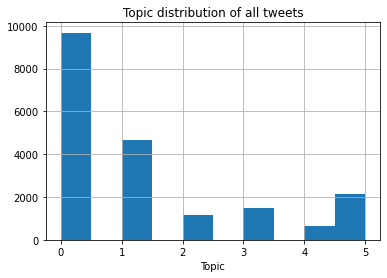

In [30]:
#explicitly get topic distribution (to get total number of tweets per topic)
def get_top_topic(distribution):
    top_topic = 0
    top_prob = 0 
    for topic in distribution:
        if topic[1] > top_prob:
            top_topic = topic[0]
            top_prob = topic[1] 
    return top_topic
#get topic probabilities for all tweets
full_dic, full_corpus = create_dic_corpus(df['tokenized'])
df['topic distribution'] = df['tokenized'].apply(lambda x: optimal_full.get_document_topics(full_dic.doc2bow(x)))
df['topic'] = df['topic distribution'].apply(lambda x: get_top_topic(x))
#distribution of topics
df['topic'].hist()
plt.title('Topic distribution of all tweets')
plt.xlabel('Topic')
plt.show()

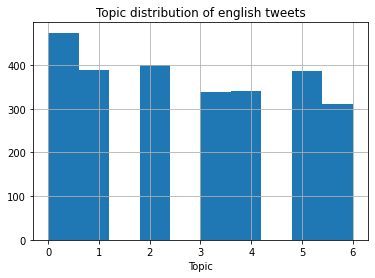

In [31]:
#get topic probabilities for all tweets
en_dic, en_corpus = create_dic_corpus(df_en['tokenized'])
df_en['topic distribution'] = df_en['tokenized'].apply(lambda x: optimal_en.get_document_topics(en_dic.doc2bow(x)))
df_en['topic'] = df_en['topic distribution'].apply(lambda x: get_top_topic(x))
#distribution of topics
df_en['topic'].hist()
plt.title('Topic distribution of english tweets')
plt.xlabel('Topic')
plt.show()

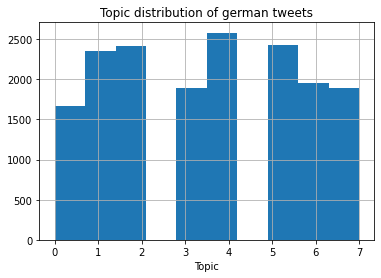

In [32]:
#get topic probabilities for all tweets
ger_dic, ger_corpus = create_dic_corpus(df_ger['tokenized'])
df_ger['topic distribution'] = df_ger['tokenized'].apply(lambda x: optimal_ger.get_document_topics(ger_dic.doc2bow(x)))
df_ger['topic'] = df_ger['topic distribution'].apply(lambda x: get_top_topic(x))
#distribution of topics
df_ger['topic'].hist()
plt.title('Topic distribution of german tweets')
plt.xlabel('Topic')
plt.show()

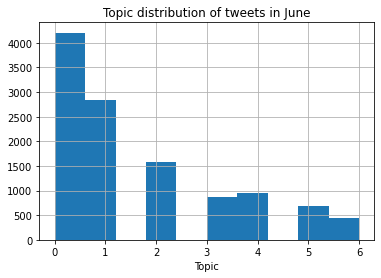

In [33]:
#get topic probabilities for all tweets
june_dic, june_corpus = create_dic_corpus(df_june['tokenized'])
df_june['topic distribution'] = df_june['tokenized'].apply(lambda x: optimal_june.get_document_topics(june_dic.doc2bow(x)))
df_june['topic'] = df_june['topic distribution'].apply(lambda x: get_top_topic(x))
#distribution of topics
df_june['topic'].hist()
plt.title('Topic distribution of tweets in June')
plt.xlabel('Topic')
plt.show()

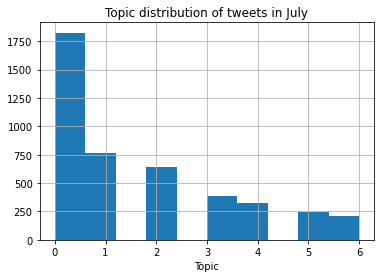

In [34]:
#get topic probabilities for all tweets
july_dic, july_corpus = create_dic_corpus(df_july['tokenized'])
df_july['topic distribution'] = df_july['tokenized'].apply(lambda x: optimal_july.get_document_topics(july_dic.doc2bow(x)))
df_july['topic'] = df_july['topic distribution'].apply(lambda x: get_top_topic(x))
#distribution of topics
df_july['topic'].hist()
plt.title('Topic distribution of tweets in July')
plt.xlabel('Topic')
plt.show()

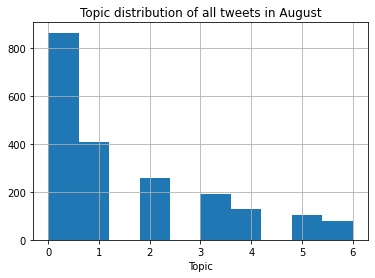

In [35]:
#get topic probabilities for all tweets
august_dic, august_corpus = create_dic_corpus(df_august['tokenized'])
df_august['topic distribution'] = df_august['tokenized'].apply(lambda x: optimal_august.get_document_topics(august_dic.doc2bow(x)))
df_august['topic'] = df_august['topic distribution'].apply(lambda x: get_top_topic(x))
#distribution of topics
df_august['topic'].hist()
plt.title('Topic distribution of all tweets in August')
plt.xlabel('Topic')
plt.show()

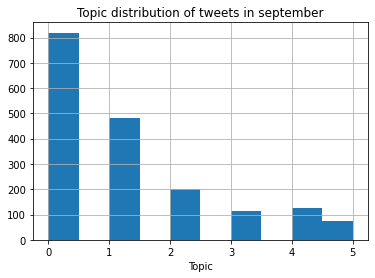

In [36]:
#get topic probabilities for all tweets
september_dic, september_corpus = create_dic_corpus(df_september['tokenized'])
df_september['topic distribution'] = df_september['tokenized'].apply(lambda x: optimal_september.get_document_topics(september_dic.doc2bow(x)))
df_september['topic'] = df_september['topic distribution'].apply(lambda x: get_top_topic(x))
#distribution of topics
df_september['topic'].hist()
plt.title('Topic distribution of tweets in september')
plt.xlabel('Topic')
plt.show()

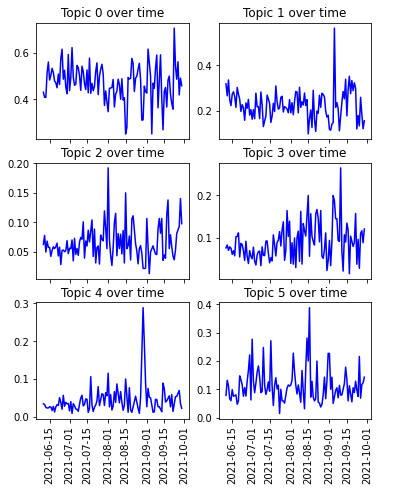

In [37]:
#show the development of tweet frequency of topics over time for the whole set; not particularly insightful for full data
df_topic0 = df.loc[df['topic'] == 0]
df_topic1 = df.loc[df['topic'] == 1]
df_topic2 = df.loc[df['topic'] == 2]
df_topic3 = df.loc[df['topic'] == 3]
df_topic4 = df.loc[df['topic'] == 4]
df_topic5 = df.loc[df['topic'] == 5]
#divide number of tweets of a topic at a day by the total number of topics on that day, to lessen the effect of days with a high tweet frequency
df_freqs = pd.DataFrame(pd.to_datetime(df['new_date']).dt.date.value_counts()).reset_index().sort_values('index')
df_topic0 = pd.DataFrame(pd.to_datetime(df_topic0['new_date']).dt.date.value_counts()).reset_index().sort_values('index')
df_topic0 = df_topic0.merge(df_freqs, on ='index')
df_topic0['count'] = df_topic0['new_date_x']/df_topic0['new_date_y'] 
df_topic1 = pd.DataFrame(pd.to_datetime(df_topic1['new_date']).dt.date.value_counts()).reset_index().sort_values('index')
df_topic1 = df_topic1.merge(df_freqs, on ='index')
df_topic1['count'] = df_topic1['new_date_x']/df_topic1['new_date_y'] 
df_topic2 = pd.DataFrame(pd.to_datetime(df_topic2['new_date']).dt.date.value_counts()).reset_index().sort_values('index')
df_topic2 = df_topic2.merge(df_freqs, on ='index')
df_topic2['count'] = df_topic2['new_date_x']/df_topic2['new_date_y'] 
df_topic3 = pd.DataFrame(pd.to_datetime(df_topic3['new_date']).dt.date.value_counts()).reset_index().sort_values('index')
df_topic3 = df_topic3.merge(df_freqs, on ='index')
df_topic3['count'] = df_topic3['new_date_x']/df_topic3['new_date_y'] 
df_topic4 = pd.DataFrame(pd.to_datetime(df_topic4['new_date']).dt.date.value_counts()).reset_index().sort_values('index')
df_topic4 = df_topic4.merge(df_freqs, on ='index')
df_topic4['count'] = df_topic4['new_date_x']/df_topic4['new_date_y'] 
df_topic5 = pd.DataFrame(pd.to_datetime(df_topic5['new_date']).dt.date.value_counts()).reset_index().sort_values('index')
df_topic5 = df_topic5.merge(df_freqs, on ='index')
df_topic5['count'] = df_topic5['new_date_x']/df_topic5['new_date_y']
plt.subplot(3, 2, 1)
plt.title('Topic 0 over time')
plt.plot(df_topic0['index'], df_topic0['count'], color='blue')
plt.xticks(color='w')
plt.subplot(3, 2, 2)
plt.title('Topic 1 over time')
plt.plot(df_topic1['index'], df_topic1['count'], color='blue')
plt.xticks(color='w')
plt.subplot(3, 2, 3)
plt.title('Topic 2 over time')
plt.plot(df_topic2['index'], df_topic2['count'], color='blue')
plt.xticks(color='w')
plt.subplot(3, 2, 4)
plt.title('Topic 3 over time')
plt.plot(df_topic3['index'], df_topic3['count'], color='blue')
plt.xticks(color='w')
plt.subplot(3, 2, 5)
plt.title('Topic 4 over time')
plt.plot(df_topic4['index'], df_topic4['count'], color='blue')
plt.xticks(rotation='vertical')
plt.subplot(3, 2, 6)
plt.title('Topic 5 over time')
plt.plot(df_topic5['index'], df_topic5['count'], color='blue')
plt.xticks(rotation='vertical')
plt.subplots_adjust(top=1.5)
plt.show()

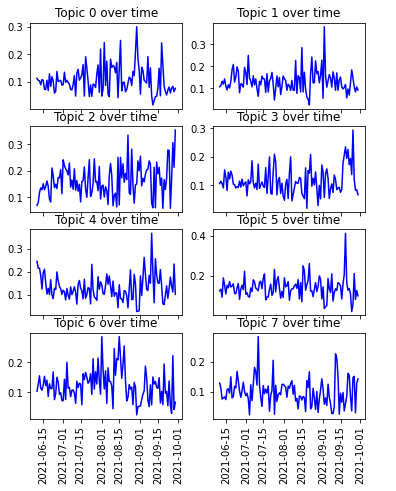

In [39]:
#show the development of tweet frequency of topics over time for the german tweets
df_ger_topic0 = df_ger.loc[df_ger['topic'] == 0]
df_ger_topic1 = df_ger.loc[df_ger['topic'] == 1]
df_ger_topic2 = df_ger.loc[df_ger['topic'] == 2]
df_ger_topic3 = df_ger.loc[df_ger['topic'] == 3]
df_ger_topic4 = df_ger.loc[df_ger['topic'] == 4]
df_ger_topic5 = df_ger.loc[df_ger['topic'] == 5]
df_ger_topic6 = df_ger.loc[df_ger['topic'] == 6]
df_ger_topic7 = df_ger.loc[df_ger['topic'] == 7]
df_ger_freqs = pd.DataFrame(pd.to_datetime(df_ger['new_date']).dt.date.value_counts()).reset_index().sort_values('index')
df_ger_topic0 = pd.DataFrame(pd.to_datetime(df_ger_topic0['new_date']).dt.date.value_counts()).reset_index().sort_values('index')
df_ger_topic0 = df_ger_topic0.merge(df_ger_freqs, on ='index')
df_ger_topic0['count'] = df_ger_topic0['new_date_x']/df_ger_topic0['new_date_y'] 
df_ger_topic1 = pd.DataFrame(pd.to_datetime(df_ger_topic1['new_date']).dt.date.value_counts()).reset_index().sort_values('index')
df_ger_topic1 = df_ger_topic1.merge(df_ger_freqs, on ='index')
df_ger_topic1['count'] = df_ger_topic1['new_date_x']/df_ger_topic1['new_date_y'] 
df_ger_topic2 = pd.DataFrame(pd.to_datetime(df_ger_topic2['new_date']).dt.date.value_counts()).reset_index().sort_values('index')
df_ger_topic2 = df_ger_topic2.merge(df_ger_freqs, on ='index')
df_ger_topic2['count'] = df_ger_topic2['new_date_x']/df_ger_topic2['new_date_y'] 
df_ger_topic3 = pd.DataFrame(pd.to_datetime(df_ger_topic3['new_date']).dt.date.value_counts()).reset_index().sort_values('index')
df_ger_topic3 = df_ger_topic3.merge(df_ger_freqs, on ='index')
df_ger_topic3['count'] = df_ger_topic3['new_date_x']/df_ger_topic3['new_date_y'] 
df_ger_topic4 = pd.DataFrame(pd.to_datetime(df_ger_topic4['new_date']).dt.date.value_counts()).reset_index().sort_values('index')
df_ger_topic4 = df_ger_topic4.merge(df_ger_freqs, on ='index')
df_ger_topic4['count'] = df_ger_topic4['new_date_x']/df_ger_topic4['new_date_y'] 
df_ger_topic5 = pd.DataFrame(pd.to_datetime(df_ger_topic5['new_date']).dt.date.value_counts()).reset_index().sort_values('index')
df_ger_topic5 = df_ger_topic5.merge(df_ger_freqs, on ='index')
df_ger_topic5['count'] = df_ger_topic5['new_date_x']/df_ger_topic5['new_date_y']
df_ger_topic6 = pd.DataFrame(pd.to_datetime(df_ger_topic6['new_date']).dt.date.value_counts()).reset_index().sort_values('index')
df_ger_topic6 = df_ger_topic6.merge(df_ger_freqs, on ='index')
df_ger_topic6['count'] = df_ger_topic6['new_date_x']/df_ger_topic6['new_date_y'] 
df_ger_topic7 = pd.DataFrame(pd.to_datetime(df_ger_topic7['new_date']).dt.date.value_counts()).reset_index().sort_values('index')
df_ger_topic7 = df_ger_topic7.merge(df_ger_freqs, on ='index')
df_ger_topic7['count'] = df_ger_topic7['new_date_x']/df_ger_topic7['new_date_y'] 
plt.subplot(4, 2, 1)
plt.title('Topic 0 over time')
plt.plot(df_ger_topic0['index'], df_ger_topic0['count'], color='blue')
plt.xticks(color='w')
plt.subplot(4, 2, 2)
plt.title('Topic 1 over time')
plt.plot(df_ger_topic1['index'], df_ger_topic1['count'], color='blue')
plt.xticks(color='w')
plt.subplot(4, 2, 3)
plt.title('Topic 2 over time')
plt.plot(df_ger_topic2['index'], df_ger_topic2['count'], color='blue')
plt.xticks(color='w')
plt.subplot(4, 2, 4)
plt.title('Topic 3 over time')
plt.plot(df_ger_topic3['index'], df_ger_topic3['count'], color='blue')
plt.xticks(color='w')
plt.subplot(4, 2, 5)
plt.title('Topic 4 over time')
plt.plot(df_ger_topic4['index'], df_ger_topic4['count'], color='blue')
plt.xticks(rotation='vertical')
plt.xticks(color='w')
plt.subplot(4, 2, 6)
plt.title('Topic 5 over time')
plt.plot(df_ger_topic5['index'], df_ger_topic5['count'], color='blue')
plt.xticks(rotation='vertical')
plt.xticks(color='w')
plt.subplot(4, 2, 7)
plt.title('Topic 6 over time')
plt.plot(df_ger_topic6['index'], df_ger_topic6['count'], color='blue')
plt.xticks(rotation='vertical')
plt.subplot(4, 2, 8)
plt.title('Topic 7 over time')
plt.plot(df_ger_topic7['index'], df_ger_topic7['count'], color='blue')
plt.xticks(rotation='vertical')
plt.subplots_adjust(top=1.5)
plt.show()

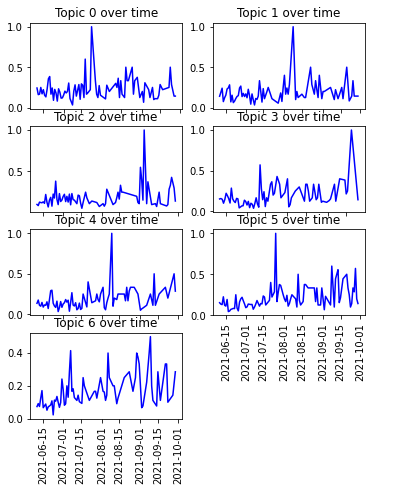

In [41]:
#show the development of tweet frequency of topics over time for the english tweets
df_en_topic0 = df_en.loc[df_en['topic'] == 0]
df_en_topic1 = df_en.loc[df_en['topic'] == 1]
df_en_topic2 = df_en.loc[df_en['topic'] == 2]
df_en_topic3 = df_en.loc[df_en['topic'] == 3]
df_en_topic4 = df_en.loc[df_en['topic'] == 4]
df_en_topic5 = df_en.loc[df_en['topic'] == 5]
df_en_topic6 = df_en.loc[df_en['topic'] == 6]
df_en_freqs = pd.DataFrame(pd.to_datetime(df_en['new_date']).dt.date.value_counts()).reset_index().sort_values('index')
df_en_topic0 = pd.DataFrame(pd.to_datetime(df_en_topic0['new_date']).dt.date.value_counts()).reset_index().sort_values('index')
df_en_topic0 = df_en_topic0.merge(df_en_freqs, on ='index')
df_en_topic0['count'] = df_en_topic0['new_date_x']/df_en_topic0['new_date_y'] 
df_en_topic1 = pd.DataFrame(pd.to_datetime(df_en_topic1['new_date']).dt.date.value_counts()).reset_index().sort_values('index')
df_en_topic1 = df_en_topic1.merge(df_en_freqs, on ='index')
df_en_topic1['count'] = df_en_topic1['new_date_x']/df_en_topic1['new_date_y'] 
df_en_topic2 = pd.DataFrame(pd.to_datetime(df_en_topic2['new_date']).dt.date.value_counts()).reset_index().sort_values('index')
df_en_topic2 = df_en_topic2.merge(df_en_freqs, on ='index')
df_en_topic2['count'] = df_en_topic2['new_date_x']/df_en_topic2['new_date_y'] 
df_en_topic3 = pd.DataFrame(pd.to_datetime(df_en_topic3['new_date']).dt.date.value_counts()).reset_index().sort_values('index')
df_en_topic3 = df_en_topic3.merge(df_en_freqs, on ='index')
df_en_topic3['count'] = df_en_topic3['new_date_x']/df_en_topic3['new_date_y'] 
df_en_topic4 = pd.DataFrame(pd.to_datetime(df_en_topic4['new_date']).dt.date.value_counts()).reset_index().sort_values('index')
df_en_topic4 = df_en_topic4.merge(df_en_freqs, on ='index')
df_en_topic4['count'] = df_en_topic4['new_date_x']/df_en_topic4['new_date_y'] 
df_en_topic5 = pd.DataFrame(pd.to_datetime(df_en_topic5['new_date']).dt.date.value_counts()).reset_index().sort_values('index')
df_en_topic5 = df_en_topic5.merge(df_en_freqs, on ='index')
df_en_topic5['count'] = df_en_topic5['new_date_x']/df_en_topic5['new_date_y']
df_en_topic6 = pd.DataFrame(pd.to_datetime(df_en_topic6['new_date']).dt.date.value_counts()).reset_index().sort_values('index')
df_en_topic6 = df_en_topic6.merge(df_en_freqs, on ='index')
df_en_topic6['count'] = df_en_topic6['new_date_x']/df_en_topic6['new_date_y'] 
plt.subplot(4, 2, 1)
plt.title('Topic 0 over time')
plt.plot(df_en_topic0['index'], df_en_topic0['count'], color='blue')
plt.xticks(color='w')
plt.subplot(4, 2, 2)
plt.title('Topic 1 over time')
plt.plot(df_en_topic1['index'], df_en_topic1['count'], color='blue')
plt.xticks(color='w')
plt.subplot(4, 2, 3)
plt.title('Topic 2 over time')
plt.plot(df_en_topic2['index'], df_en_topic2['count'], color='blue')
plt.xticks(color='w')
plt.subplot(4, 2, 4)
plt.title('Topic 3 over time')
plt.plot(df_en_topic3['index'], df_en_topic3['count'], color='blue')
plt.xticks(color='w')
plt.subplot(4, 2, 5)
plt.title('Topic 4 over time')
plt.plot(df_en_topic4['index'], df_en_topic4['count'], color='blue')
plt.xticks(rotation='vertical')
plt.xticks(color='w')
plt.subplot(4, 2, 6)
plt.title('Topic 5 over time')
plt.plot(df_en_topic5['index'], df_en_topic5['count'], color='blue')
plt.xticks(rotation='vertical')
plt.subplot(4, 2, 7)
plt.title('Topic 6 over time')
plt.plot(df_en_topic6['index'], df_en_topic6['count'], color='blue')
plt.xticks(rotation='vertical')
plt.subplots_adjust(top=1.5)
plt.show()

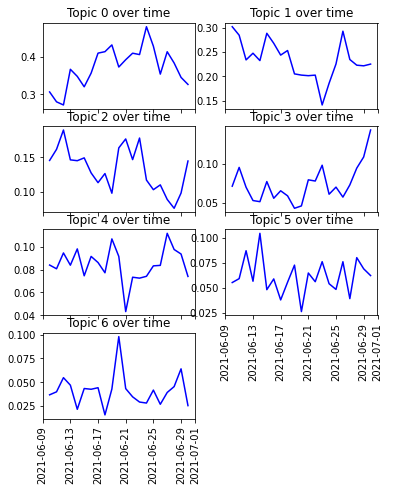

In [43]:
#show the development of tweet frequency of topics over time for the tweets in june
df_june_topic0 = df_june.loc[df_june['topic'] == 0]
df_june_topic1 = df_june.loc[df_june['topic'] == 1]
df_june_topic2 = df_june.loc[df_june['topic'] == 2]
df_june_topic3 = df_june.loc[df_june['topic'] == 3]
df_june_topic4 = df_june.loc[df_june['topic'] == 4]
df_june_topic5 = df_june.loc[df_june['topic'] == 5]
df_june_topic6 = df_june.loc[df_june['topic'] == 6]
df_june_freqs = pd.DataFrame(pd.to_datetime(df_june['new_date']).dt.date.value_counts()).reset_index().sort_values('index')
df_june_topic0 = pd.DataFrame(pd.to_datetime(df_june_topic0['new_date']).dt.date.value_counts()).reset_index().sort_values('index')
df_june_topic0 = df_june_topic0.merge(df_june_freqs, on ='index')
df_june_topic0['count'] = df_june_topic0['new_date_x']/df_june_topic0['new_date_y'] 
df_june_topic1 = pd.DataFrame(pd.to_datetime(df_june_topic1['new_date']).dt.date.value_counts()).reset_index().sort_values('index')
df_june_topic1 = df_june_topic1.merge(df_june_freqs, on ='index')
df_june_topic1['count'] = df_june_topic1['new_date_x']/df_june_topic1['new_date_y'] 
df_june_topic2 = pd.DataFrame(pd.to_datetime(df_june_topic2['new_date']).dt.date.value_counts()).reset_index().sort_values('index')
df_june_topic2 = df_june_topic2.merge(df_june_freqs, on ='index')
df_june_topic2['count'] = df_june_topic2['new_date_x']/df_june_topic2['new_date_y'] 
df_june_topic3 = pd.DataFrame(pd.to_datetime(df_june_topic3['new_date']).dt.date.value_counts()).reset_index().sort_values('index')
df_june_topic3 = df_june_topic3.merge(df_june_freqs, on ='index')
df_june_topic3['count'] = df_june_topic3['new_date_x']/df_june_topic3['new_date_y'] 
df_june_topic4 = pd.DataFrame(pd.to_datetime(df_june_topic4['new_date']).dt.date.value_counts()).reset_index().sort_values('index')
df_june_topic4 = df_june_topic4.merge(df_june_freqs, on ='index')
df_june_topic4['count'] = df_june_topic4['new_date_x']/df_june_topic4['new_date_y'] 
df_june_topic5 = pd.DataFrame(pd.to_datetime(df_june_topic5['new_date']).dt.date.value_counts()).reset_index().sort_values('index')
df_june_topic5 = df_june_topic5.merge(df_june_freqs, on ='index')
df_june_topic5['count'] = df_june_topic5['new_date_x']/df_june_topic5['new_date_y']
df_june_topic6 = pd.DataFrame(pd.to_datetime(df_june_topic6['new_date']).dt.date.value_counts()).reset_index().sort_values('index')
df_june_topic6 = df_june_topic6.merge(df_june_freqs, on ='index')
df_june_topic6['count'] = df_june_topic6['new_date_x']/df_june_topic6['new_date_y'] 
plt.subplot(4, 2, 1)
plt.title('Topic 0 over time')
plt.plot(df_june_topic0['index'], df_june_topic0['count'], color='blue')
plt.xticks(color='w')
plt.subplot(4, 2, 2)
plt.title('Topic 1 over time')
plt.plot(df_june_topic1['index'], df_june_topic1['count'], color='blue')
plt.xticks(color='w')
plt.subplot(4, 2, 3)
plt.title('Topic 2 over time')
plt.plot(df_june_topic2['index'], df_june_topic2['count'], color='blue')
plt.xticks(color='w')
plt.subplot(4, 2, 4)
plt.title('Topic 3 over time')
plt.plot(df_june_topic3['index'], df_june_topic3['count'], color='blue')
plt.xticks(color='w')
plt.subplot(4, 2, 5)
plt.title('Topic 4 over time')
plt.plot(df_june_topic4['index'], df_june_topic4['count'], color='blue')
plt.xticks(rotation='vertical')
plt.xticks(color='w')
plt.subplot(4, 2, 6)
plt.title('Topic 5 over time')
plt.plot(df_june_topic5['index'], df_june_topic5['count'], color='blue')
plt.xticks(rotation='vertical')
plt.subplot(4, 2, 7)
plt.title('Topic 6 over time')
plt.plot(df_june_topic6['index'], df_june_topic6['count'], color='blue')
plt.xticks(rotation='vertical')
plt.subplots_adjust(top=1.5)
plt.show()

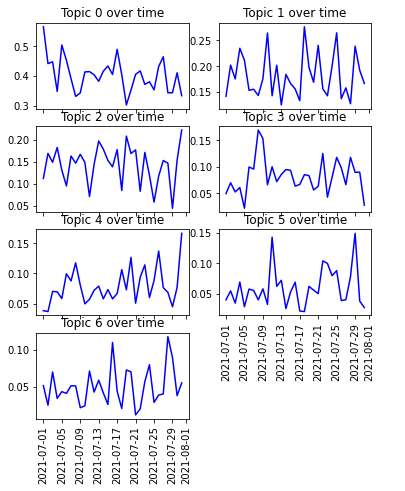

In [45]:
#show the development of tweet frequency of topics over time for the tweets in july
df_july_topic0 = df_july.loc[df_july['topic'] == 0]
df_july_topic1 = df_july.loc[df_july['topic'] == 1]
df_july_topic2 = df_july.loc[df_july['topic'] == 2]
df_july_topic3 = df_july.loc[df_july['topic'] == 3]
df_july_topic4 = df_july.loc[df_july['topic'] == 4]
df_july_topic5 = df_july.loc[df_july['topic'] == 5]
df_july_topic6 = df_july.loc[df_july['topic'] == 6]
df_july_freqs = pd.DataFrame(pd.to_datetime(df_july['new_date']).dt.date.value_counts()).reset_index().sort_values('index')
df_july_topic0 = pd.DataFrame(pd.to_datetime(df_july_topic0['new_date']).dt.date.value_counts()).reset_index().sort_values('index')
df_july_topic0 = df_july_topic0.merge(df_july_freqs, on ='index')
df_july_topic0['count'] = df_july_topic0['new_date_x']/df_july_topic0['new_date_y'] 
df_july_topic1 = pd.DataFrame(pd.to_datetime(df_july_topic1['new_date']).dt.date.value_counts()).reset_index().sort_values('index')
df_july_topic1 = df_july_topic1.merge(df_july_freqs, on ='index')
df_july_topic1['count'] = df_july_topic1['new_date_x']/df_july_topic1['new_date_y'] 
df_july_topic2 = pd.DataFrame(pd.to_datetime(df_july_topic2['new_date']).dt.date.value_counts()).reset_index().sort_values('index')
df_july_topic2 = df_july_topic2.merge(df_july_freqs, on ='index')
df_july_topic2['count'] = df_july_topic2['new_date_x']/df_july_topic2['new_date_y'] 
df_july_topic3 = pd.DataFrame(pd.to_datetime(df_july_topic3['new_date']).dt.date.value_counts()).reset_index().sort_values('index')
df_july_topic3 = df_july_topic3.merge(df_july_freqs, on ='index')
df_july_topic3['count'] = df_july_topic3['new_date_x']/df_july_topic3['new_date_y'] 
df_july_topic4 = pd.DataFrame(pd.to_datetime(df_july_topic4['new_date']).dt.date.value_counts()).reset_index().sort_values('index')
df_july_topic4 = df_july_topic4.merge(df_july_freqs, on ='index')
df_july_topic4['count'] = df_july_topic4['new_date_x']/df_july_topic4['new_date_y'] 
df_july_topic5 = pd.DataFrame(pd.to_datetime(df_july_topic5['new_date']).dt.date.value_counts()).reset_index().sort_values('index')
df_july_topic5 = df_july_topic5.merge(df_july_freqs, on ='index')
df_july_topic5['count'] = df_july_topic5['new_date_x']/df_july_topic5['new_date_y']
df_july_topic6 = pd.DataFrame(pd.to_datetime(df_july_topic6['new_date']).dt.date.value_counts()).reset_index().sort_values('index')
df_july_topic6 = df_july_topic6.merge(df_july_freqs, on ='index')
df_july_topic6['count'] = df_july_topic6['new_date_x']/df_july_topic6['new_date_y'] 
plt.subplot(4, 2, 1)
plt.title('Topic 0 over time')
plt.plot(df_july_topic0['index'], df_july_topic0['count'], color='blue')
plt.xticks(color='w')
plt.subplot(4, 2, 2)
plt.title('Topic 1 over time')
plt.plot(df_july_topic1['index'], df_july_topic1['count'], color='blue')
plt.xticks(color='w')
plt.subplot(4, 2, 3)
plt.title('Topic 2 over time')
plt.plot(df_july_topic2['index'], df_july_topic2['count'], color='blue')
plt.xticks(color='w')
plt.subplot(4, 2, 4)
plt.title('Topic 3 over time')
plt.plot(df_july_topic3['index'], df_july_topic3['count'], color='blue')
plt.xticks(color='w')
plt.subplot(4, 2, 5)
plt.title('Topic 4 over time')
plt.plot(df_july_topic4['index'], df_july_topic4['count'], color='blue')
plt.xticks(rotation='vertical')
plt.xticks(color='w')
plt.subplot(4, 2, 6)
plt.title('Topic 5 over time')
plt.plot(df_july_topic5['index'], df_july_topic5['count'], color='blue')
plt.xticks(rotation='vertical')
plt.subplot(4, 2, 7)
plt.title('Topic 6 over time')
plt.plot(df_july_topic6['index'], df_july_topic6['count'], color='blue')
plt.xticks(rotation='vertical')
plt.subplots_adjust(top=1.5)
plt.show()

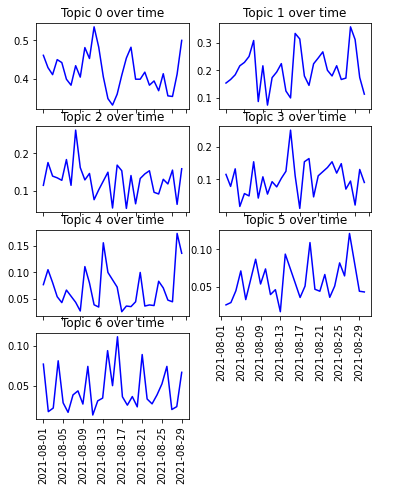

In [46]:
#show the development of tweet frequency of topics over time for the tweets in august
df_august_topic0 = df_august.loc[df_august['topic'] == 0]
df_august_topic1 = df_august.loc[df_august['topic'] == 1]
df_august_topic2 = df_august.loc[df_august['topic'] == 2]
df_august_topic3 = df_august.loc[df_august['topic'] == 3]
df_august_topic4 = df_august.loc[df_august['topic'] == 4]
df_august_topic5 = df_august.loc[df_august['topic'] == 5]
df_august_topic6 = df_august.loc[df_august['topic'] == 6]
df_august_freqs = pd.DataFrame(pd.to_datetime(df_august['new_date']).dt.date.value_counts()).reset_index().sort_values('index')
df_august_topic0 = pd.DataFrame(pd.to_datetime(df_august_topic0['new_date']).dt.date.value_counts()).reset_index().sort_values('index')
df_august_topic0 = df_august_topic0.merge(df_august_freqs, on ='index')
df_august_topic0['count'] = df_august_topic0['new_date_x']/df_august_topic0['new_date_y'] 
df_august_topic1 = pd.DataFrame(pd.to_datetime(df_august_topic1['new_date']).dt.date.value_counts()).reset_index().sort_values('index')
df_august_topic1 = df_august_topic1.merge(df_august_freqs, on ='index')
df_august_topic1['count'] = df_august_topic1['new_date_x']/df_august_topic1['new_date_y'] 
df_august_topic2 = pd.DataFrame(pd.to_datetime(df_august_topic2['new_date']).dt.date.value_counts()).reset_index().sort_values('index')
df_august_topic2 = df_august_topic2.merge(df_august_freqs, on ='index')
df_august_topic2['count'] = df_august_topic2['new_date_x']/df_august_topic2['new_date_y'] 
df_august_topic3 = pd.DataFrame(pd.to_datetime(df_august_topic3['new_date']).dt.date.value_counts()).reset_index().sort_values('index')
df_august_topic3 = df_august_topic3.merge(df_august_freqs, on ='index')
df_august_topic3['count'] = df_august_topic3['new_date_x']/df_august_topic3['new_date_y'] 
df_august_topic4 = pd.DataFrame(pd.to_datetime(df_august_topic4['new_date']).dt.date.value_counts()).reset_index().sort_values('index')
df_august_topic4 = df_august_topic4.merge(df_august_freqs, on ='index')
df_august_topic4['count'] = df_august_topic4['new_date_x']/df_august_topic4['new_date_y'] 
df_august_topic5 = pd.DataFrame(pd.to_datetime(df_august_topic5['new_date']).dt.date.value_counts()).reset_index().sort_values('index')
df_august_topic5 = df_august_topic5.merge(df_august_freqs, on ='index')
df_august_topic5['count'] = df_august_topic5['new_date_x']/df_august_topic5['new_date_y']
df_august_topic6 = pd.DataFrame(pd.to_datetime(df_august_topic6['new_date']).dt.date.value_counts()).reset_index().sort_values('index')
df_august_topic6 = df_august_topic6.merge(df_august_freqs, on ='index')
df_august_topic6['count'] = df_august_topic6['new_date_x']/df_august_topic6['new_date_y'] 
plt.subplot(4, 2, 1)
plt.title('Topic 0 over time')
plt.plot(df_august_topic0['index'], df_august_topic0['count'], color='blue')
plt.xticks(color='w')
plt.subplot(4, 2, 2)
plt.title('Topic 1 over time')
plt.plot(df_august_topic1['index'], df_august_topic1['count'], color='blue')
plt.xticks(color='w')
plt.subplot(4, 2, 3)
plt.title('Topic 2 over time')
plt.plot(df_august_topic2['index'], df_august_topic2['count'], color='blue')
plt.xticks(color='w')
plt.subplot(4, 2, 4)
plt.title('Topic 3 over time')
plt.plot(df_august_topic3['index'], df_august_topic3['count'], color='blue')
plt.xticks(color='w')
plt.subplot(4, 2, 5)
plt.title('Topic 4 over time')
plt.plot(df_august_topic4['index'], df_august_topic4['count'], color='blue')
plt.xticks(rotation='vertical')
plt.xticks(color='w')
plt.subplot(4, 2, 6)
plt.title('Topic 5 over time')
plt.plot(df_august_topic5['index'], df_august_topic5['count'], color='blue')
plt.xticks(rotation='vertical')
plt.subplot(4, 2, 7)
plt.title('Topic 6 over time')
plt.plot(df_august_topic6['index'], df_august_topic6['count'], color='blue')
plt.xticks(rotation='vertical')
plt.subplots_adjust(top=1.5)
plt.show()

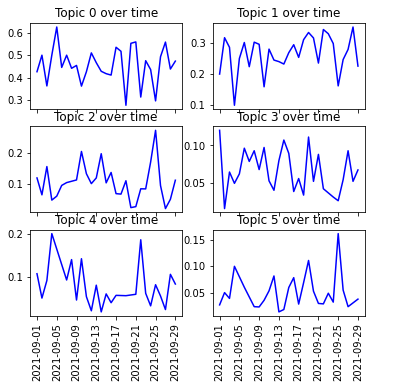

In [48]:
#show the development of tweet frequency of topics over time for the tweets in august
df_september_topic0 = df_september.loc[df_september['topic'] == 0]
df_september_topic1 = df_september.loc[df_september['topic'] == 1]
df_september_topic2 = df_september.loc[df_september['topic'] == 2]
df_september_topic3 = df_september.loc[df_september['topic'] == 3]
df_september_topic4 = df_september.loc[df_september['topic'] == 4]
df_september_topic5 = df_september.loc[df_september['topic'] == 5]
df_september_freqs = pd.DataFrame(pd.to_datetime(df_september['new_date']).dt.date.value_counts()).reset_index().sort_values('index')
df_september_topic0 = pd.DataFrame(pd.to_datetime(df_september_topic0['new_date']).dt.date.value_counts()).reset_index().sort_values('index')
df_september_topic0 = df_september_topic0.merge(df_september_freqs, on ='index')
df_september_topic0['count'] = df_september_topic0['new_date_x']/df_september_topic0['new_date_y'] 
df_september_topic1 = pd.DataFrame(pd.to_datetime(df_september_topic1['new_date']).dt.date.value_counts()).reset_index().sort_values('index')
df_september_topic1 = df_september_topic1.merge(df_september_freqs, on ='index')
df_september_topic1['count'] = df_september_topic1['new_date_x']/df_september_topic1['new_date_y'] 
df_september_topic2 = pd.DataFrame(pd.to_datetime(df_september_topic2['new_date']).dt.date.value_counts()).reset_index().sort_values('index')
df_september_topic2 = df_september_topic2.merge(df_september_freqs, on ='index')
df_september_topic2['count'] = df_september_topic2['new_date_x']/df_september_topic2['new_date_y'] 
df_september_topic3 = pd.DataFrame(pd.to_datetime(df_september_topic3['new_date']).dt.date.value_counts()).reset_index().sort_values('index')
df_september_topic3 = df_september_topic3.merge(df_september_freqs, on ='index')
df_september_topic3['count'] = df_september_topic3['new_date_x']/df_september_topic3['new_date_y'] 
df_september_topic4 = pd.DataFrame(pd.to_datetime(df_september_topic4['new_date']).dt.date.value_counts()).reset_index().sort_values('index')
df_september_topic4 = df_september_topic4.merge(df_september_freqs, on ='index')
df_september_topic4['count'] = df_september_topic4['new_date_x']/df_september_topic4['new_date_y'] 
df_september_topic5 = pd.DataFrame(pd.to_datetime(df_september_topic5['new_date']).dt.date.value_counts()).reset_index().sort_values('index')
df_september_topic5 = df_september_topic5.merge(df_september_freqs, on ='index')
df_september_topic5['count'] = df_september_topic5['new_date_x']/df_september_topic5['new_date_y']
plt.subplot(4, 2, 1)
plt.title('Topic 0 over time')
plt.plot(df_september_topic0['index'], df_september_topic0['count'], color='blue')
plt.xticks(color='w')
plt.subplot(4, 2, 2)
plt.title('Topic 1 over time')
plt.plot(df_september_topic1['index'], df_september_topic1['count'], color='blue')
plt.xticks(color='w')
plt.subplot(4, 2, 3)
plt.title('Topic 2 over time')
plt.plot(df_september_topic2['index'], df_september_topic2['count'], color='blue')
plt.xticks(color='w')
plt.subplot(4, 2, 4)
plt.title('Topic 3 over time')
plt.plot(df_september_topic3['index'], df_september_topic3['count'], color='blue')
plt.xticks(color='w')
plt.subplot(4, 2, 5)
plt.title('Topic 4 over time')
plt.plot(df_september_topic4['index'], df_september_topic4['count'], color='blue')
plt.xticks(rotation='vertical')
plt.subplot(4, 2, 6)
plt.title('Topic 5 over time')
plt.plot(df_september_topic5['index'], df_september_topic5['count'], color='blue')
plt.xticks(rotation='vertical')
plt.subplots_adjust(top=1.5)
plt.show()

## Proportion of topics within user groups

In [61]:
#identify different user groups for whole data set
df_pos = df.loc[df['user.group'] == "Postdoc"]
df_prom = df.loc[df['user.group'] == "Promovierende"]
df_stu = df.loc[df['user.group'] == "Student"]
df_prof = df.loc[df['user.group'] == "Prof"]
df_med = df.loc[df['user.group'] == "Media"]
df_pol = df.loc[df['user.group'] == "Political rep"]
df_uni = df.loc[df['user.group'] == "Union rep"]
df_ins = df.loc[df['user.group'] == "Institution"]
df_bot = df.loc[df['user.group'] == "Bot"]
df_jun = df.loc[df['user.group'] == "Jun. prof"]
df_tea = df.loc[df['user.group'] == "Teacher"]
df_medic = df.loc[df['user.group'] == "Medical doctor"]
#get the tweets per topic and divide it by the whole amount of tweets for that group to get the proportions
df_pos_count = pd.DataFrame(df_pos['topic'].value_counts())
df_pos_count['topic'] = df_pos_count['topic']/len(df_pos) 
df_prom_count = pd.DataFrame(df_prom['topic'].value_counts())
df_prom_count['topic'] = df_prom_count['topic']/len(df_prom) 
df_stu_count = pd.DataFrame(df_stu['topic'].value_counts())
df_stu_count['topic'] = df_stu_count['topic']/len(df_stu) 
df_prof_count = pd.DataFrame(df_prof['topic'].value_counts())
df_prof_count['topic'] = df_prof_count['topic']/len(df_prof) 
df_med_count = pd.DataFrame(df_med['topic'].value_counts())
df_med_count['topic'] = df_med_count['topic']/len(df_med) 
df_pol_count = pd.DataFrame(df_pol['topic'].value_counts())
df_pol_count['topic'] = df_pol_count['topic']/len(df_pol) 
df_uni_count = pd.DataFrame(df_uni['topic'].value_counts())
df_uni_count['topic'] = df_uni_count['topic']/len(df_uni) 
df_ins_count = pd.DataFrame(df_ins['topic'].value_counts())
df_ins_count['topic'] = df_ins_count['topic']/len(df_ins) 
df_bot_count = pd.DataFrame(df_bot['topic'].value_counts())
df_bot_count['topic'] = df_bot_count['topic']/len(df_bot) 
df_jun_count = pd.DataFrame(df_jun['topic'].value_counts())
df_jun_count['topic'] = df_jun_count['topic']/len(df_jun) 
df_tea_count = pd.DataFrame(df_tea['topic'].value_counts())
df_tea_count['topic'] = df_tea_count['topic']/len(df_tea) 
df_medic_count = pd.DataFrame(df_medic['topic'].value_counts())
df_medic_count['topic'] = df_medic_count['topic']/len(df_medic)
print(df_pos_count)
print(df_prom_count)
print(df_stu_count)
print(df_prof_count)
print(df_med_count)
print(df_pol_count)
print(df_uni_count)
print(df_ins_count)
print(df_bot_count)
print(df_jun_count)
print(df_tea_count)
print(df_medic_count)

      topic
0  0.469509
1  0.216945
5  0.143911
3  0.078072
2  0.059363
4  0.032200
      topic
0  0.450495
1  0.232673
5  0.145215
3  0.083333
2  0.049505
4  0.038779
      topic
0  0.575000
1  0.208333
5  0.079167
2  0.062500
3  0.045833
4  0.029167
      topic
0  0.460356
1  0.207929
5  0.155340
2  0.077670
3  0.059871
4  0.038835
      topic
0  0.501319
1  0.261214
4  0.076517
3  0.073879
2  0.071240
5  0.015831
      topic
0  0.594203
1  0.202899
3  0.137681
4  0.028986
2  0.021739
5  0.014493
      topic
0  0.612698
5  0.136508
1  0.104762
3  0.092063
4  0.028571
2  0.025397
      topic
0  0.588235
1  0.191950
3  0.080495
5  0.052632
2  0.043344
4  0.043344
      topic
0  0.500000
4  0.166667
3  0.150000
1  0.116667
2  0.066667
      topic
0  0.477778
1  0.244444
2  0.111111
5  0.077778
3  0.066667
4  0.022222
   topic
1   0.40
0   0.36
2   0.12
3   0.12
   topic
0    1.0


In [62]:
#identify different user groups for german data set
df_pos = df_ger.loc[df_ger['user.group'] == "Postdoc"]
df_prom = df_ger.loc[df_ger['user.group'] == "Promovierende"]
df_stu = df_ger.loc[df_ger['user.group'] == "Student"]
df_prof = df_ger.loc[df_ger['user.group'] == "Prof"]
df_med = df_ger.loc[df_ger['user.group'] == "Media"]
df_pol = df_ger.loc[df_ger['user.group'] == "Political rep"]
df_uni = df_ger.loc[df_ger['user.group'] == "Union rep"]
df_ins = df_ger.loc[df_ger['user.group'] == "Institution"]
df_bot = df_ger.loc[df_ger['user.group'] == "Bot"]
df_jun = df_ger.loc[df_ger['user.group'] == "Jun. prof"]
df_tea = df_ger.loc[df_ger['user.group'] == "Teacher"]
df_medic = df_ger.loc[df_ger['user.group'] == "Medical doctor"]
#get the tweets per topic and divide it by the whole amount of tweets for that group to get the proportions
df_pos_count = pd.DataFrame(df_pos['topic'].value_counts())
df_pos_count['topic'] = df_pos_count['topic']/len(df_pos) 
df_prom_count = pd.DataFrame(df_prom['topic'].value_counts())
df_prom_count['topic'] = df_prom_count['topic']/len(df_prom) 
df_stu_count = pd.DataFrame(df_stu['topic'].value_counts())
df_stu_count['topic'] = df_stu_count['topic']/len(df_stu) 
df_prof_count = pd.DataFrame(df_prof['topic'].value_counts())
df_prof_count['topic'] = df_prof_count['topic']/len(df_prof) 
df_med_count = pd.DataFrame(df_med['topic'].value_counts())
df_med_count['topic'] = df_med_count['topic']/len(df_med) 
df_pol_count = pd.DataFrame(df_pol['topic'].value_counts())
df_pol_count['topic'] = df_pol_count['topic']/len(df_pol) 
df_uni_count = pd.DataFrame(df_uni['topic'].value_counts())
df_uni_count['topic'] = df_uni_count['topic']/len(df_uni) 
df_ins_count = pd.DataFrame(df_ins['topic'].value_counts())
df_ins_count['topic'] = df_ins_count['topic']/len(df_ins) 
df_bot_count = pd.DataFrame(df_bot['topic'].value_counts())
df_bot_count['topic'] = df_bot_count['topic']/len(df_bot) 
df_jun_count = pd.DataFrame(df_jun['topic'].value_counts())
df_jun_count['topic'] = df_jun_count['topic']/len(df_jun) 
df_tea_count = pd.DataFrame(df_tea['topic'].value_counts())
df_tea_count['topic'] = df_tea_count['topic']/len(df_tea) 
df_medic_count = pd.DataFrame(df_medic['topic'].value_counts())
df_medic_count['topic'] = df_medic_count['topic']/len(df_medic)
print(df_pos_count)
print(df_prom_count)
print(df_stu_count)
print(df_prof_count)
print(df_med_count)
print(df_pol_count)
print(df_uni_count)
print(df_ins_count)
print(df_bot_count)
print(df_jun_count)
print(df_tea_count)
print(df_medic_count)

      topic
2  0.144142
5  0.142826
1  0.130978
4  0.130101
6  0.120448
3  0.119351
7  0.114305
0  0.097850
      topic
5  0.165010
4  0.144135
1  0.130219
2  0.127237
3  0.119284
6  0.117296
7  0.112326
0  0.084493
      topic
4  0.178404
1  0.159624
3  0.136150
2  0.131455
5  0.112676
0  0.107981
6  0.089202
7  0.084507
   topic
1  0.173
4  0.155
3  0.150
6  0.125
5  0.122
2  0.102
7  0.093
0  0.080
      topic
6  0.193460
4  0.149864
5  0.141689
3  0.114441
1  0.106267
2  0.103542
7  0.098093
0  0.092643
      topic
2  0.210145
5  0.202899
1  0.137681
4  0.130435
7  0.108696
0  0.108696
6  0.065217
3  0.036232
      topic
2  0.578073
1  0.089701
0  0.073090
6  0.069767
5  0.063123
3  0.049834
7  0.049834
4  0.026578
      topic
2  0.214521
1  0.145215
3  0.122112
0  0.122112
7  0.115512
6  0.112211
4  0.089109
5  0.079208
      topic
6  0.232143
1  0.214286
3  0.125000
2  0.107143
7  0.107143
4  0.089286
5  0.071429
0  0.053571
      topic
4  0.172840
7  0.160494
6  0.160494
5  0.14

In [63]:
#identify different user groups for english data set
df_pos = df_en.loc[df_en['user.group'] == "Postdoc"]
df_prom = df_en.loc[df_en['user.group'] == "Promovierende"]
df_stu = df_en.loc[df_en['user.group'] == "Student"]
df_prof = df_en.loc[df_en['user.group'] == "Prof"]
df_med = df_en.loc[df_en['user.group'] == "Media"]
df_pol = df_en.loc[df_en['user.group'] == "Political rep"]
df_uni = df_en.loc[df_en['user.group'] == "Union rep"]
df_ins = df_en.loc[df_en['user.group'] == "Institution"]
df_bot = df_en.loc[df_en['user.group'] == "Bot"]
df_jun = df_en.loc[df_en['user.group'] == "Jun. prof"]
df_tea = df_en.loc[df_en['user.group'] == "Teacher"]
df_medic = df_en.loc[df_en['user.group'] == "Medical doctor"]
#get the tweets per topic and divide it by the whole amount of tweets for that group to get the proportions
df_pos_count = pd.DataFrame(df_pos['topic'].value_counts())
df_pos_count['topic'] = df_pos_count['topic']/len(df_pos) 
df_prom_count = pd.DataFrame(df_prom['topic'].value_counts())
df_prom_count['topic'] = df_prom_count['topic']/len(df_prom) 
df_stu_count = pd.DataFrame(df_stu['topic'].value_counts())
df_stu_count['topic'] = df_stu_count['topic']/len(df_stu) 
df_prof_count = pd.DataFrame(df_prof['topic'].value_counts())
df_prof_count['topic'] = df_prof_count['topic']/len(df_prof) 
df_med_count = pd.DataFrame(df_med['topic'].value_counts())
df_med_count['topic'] = df_med_count['topic']/len(df_med) 
df_pol_count = pd.DataFrame(df_pol['topic'].value_counts())
df_pol_count['topic'] = df_pol_count['topic']/len(df_pol) 
df_uni_count = pd.DataFrame(df_uni['topic'].value_counts())
df_uni_count['topic'] = df_uni_count['topic']/len(df_uni) 
df_ins_count = pd.DataFrame(df_ins['topic'].value_counts())
df_ins_count['topic'] = df_ins_count['topic']/len(df_ins) 
df_bot_count = pd.DataFrame(df_bot['topic'].value_counts())
df_bot_count['topic'] = df_bot_count['topic']/len(df_bot) 
df_jun_count = pd.DataFrame(df_jun['topic'].value_counts())
df_jun_count['topic'] = df_jun_count['topic']/len(df_jun) 
df_tea_count = pd.DataFrame(df_tea['topic'].value_counts())
df_tea_count['topic'] = df_tea_count['topic']/len(df_tea) 
df_medic_count = pd.DataFrame(df_medic['topic'].value_counts())
df_medic_count['topic'] = df_medic_count['topic']/len(df_medic)
print(df_pos_count)
print(df_prom_count)
print(df_stu_count)
print(df_prof_count)
print(df_med_count)
print(df_pol_count)
print(df_uni_count)
print(df_ins_count)
print(df_bot_count)
print(df_jun_count)
print(df_tea_count)
print(df_medic_count)

      topic
2  0.194805
0  0.171828
1  0.131868
5  0.131868
4  0.128871
6  0.121878
3  0.118881
      topic
0  0.184466
5  0.184466
1  0.169903
6  0.126214
2  0.116505
4  0.111650
3  0.106796
      topic
3  0.222222
0  0.222222
2  0.185185
4  0.111111
1  0.111111
6  0.074074
5  0.074074
      topic
1  0.177966
4  0.173729
0  0.169492
2  0.156780
5  0.122881
3  0.114407
6  0.084746
      topic
0  0.333333
4  0.250000
1  0.166667
6  0.166667
5  0.083333
Empty DataFrame
Columns: [topic]
Index: []
      topic
5  0.428571
0  0.214286
3  0.214286
1  0.142857
   topic
5   0.35
1   0.30
3   0.20
0   0.10
2   0.05
   topic
5   0.75
1   0.25
      topic
2  0.222222
5  0.222222
0  0.222222
4  0.111111
3  0.111111
1  0.111111
      topic
3  0.666667
1  0.333333
Empty DataFrame
Columns: [topic]
Index: []


In [64]:
#identify different user groups for June
df_pos = df_june.loc[df_june['user.group'] == "Postdoc"]
df_prom = df_june.loc[df_june['user.group'] == "Promovierende"]
df_stu = df_june.loc[df_june['user.group'] == "Student"]
df_prof = df_june.loc[df_june['user.group'] == "Prof"]
df_med = df_june.loc[df_june['user.group'] == "Media"]
df_pol = df_june.loc[df_june['user.group'] == "Political rep"]
df_uni = df_june.loc[df_june['user.group'] == "Union rep"]
df_ins = df_june.loc[df_june['user.group'] == "Institution"]
df_bot = df_june.loc[df_june['user.group'] == "Bot"]
df_jun = df_june.loc[df_june['user.group'] == "Jun. prof"]
df_tea = df_june.loc[df_june['user.group'] == "Teacher"]
df_medic = df_june.loc[df_june['user.group'] == "Medical doctor"]
#get the tweets per topic and divide it by the whole amount of tweets for that group to get the proportions
df_pos_count = pd.DataFrame(df_pos['topic'].value_counts())
df_pos_count['topic'] = df_pos_count['topic']/len(df_pos) 
df_prom_count = pd.DataFrame(df_prom['topic'].value_counts())
df_prom_count['topic'] = df_prom_count['topic']/len(df_prom) 
df_stu_count = pd.DataFrame(df_stu['topic'].value_counts())
df_stu_count['topic'] = df_stu_count['topic']/len(df_stu) 
df_prof_count = pd.DataFrame(df_prof['topic'].value_counts())
df_prof_count['topic'] = df_prof_count['topic']/len(df_prof) 
df_med_count = pd.DataFrame(df_med['topic'].value_counts())
df_med_count['topic'] = df_med_count['topic']/len(df_med) 
df_pol_count = pd.DataFrame(df_pol['topic'].value_counts())
df_pol_count['topic'] = df_pol_count['topic']/len(df_pol) 
df_uni_count = pd.DataFrame(df_uni['topic'].value_counts())
df_uni_count['topic'] = df_uni_count['topic']/len(df_uni) 
df_ins_count = pd.DataFrame(df_ins['topic'].value_counts())
df_ins_count['topic'] = df_ins_count['topic']/len(df_ins) 
df_bot_count = pd.DataFrame(df_bot['topic'].value_counts())
df_bot_count['topic'] = df_bot_count['topic']/len(df_bot) 
df_jun_count = pd.DataFrame(df_jun['topic'].value_counts())
df_jun_count['topic'] = df_jun_count['topic']/len(df_jun) 
df_tea_count = pd.DataFrame(df_tea['topic'].value_counts())
df_tea_count['topic'] = df_tea_count['topic']/len(df_tea) 
df_medic_count = pd.DataFrame(df_medic['topic'].value_counts())
df_medic_count['topic'] = df_medic_count['topic']/len(df_medic)
print(df_pos_count)
print(df_prom_count)
print(df_stu_count)
print(df_prof_count)
print(df_med_count)
print(df_pol_count)
print(df_uni_count)
print(df_ins_count)
print(df_bot_count)
print(df_jun_count)
print(df_tea_count)
print(df_medic_count)

      topic
0  0.396284
1  0.222297
2  0.113514
3  0.085135
4  0.081419
5  0.054054
6  0.047297
      topic
0  0.370000
1  0.238571
2  0.160000
4  0.078571
3  0.071429
5  0.048571
6  0.032857
      topic
0  0.375839
2  0.194631
1  0.194631
4  0.114094
5  0.053691
6  0.033557
3  0.033557
      topic
0  0.404639
1  0.208763
3  0.119845
2  0.097938
4  0.074742
5  0.059278
6  0.034794
      topic
0  0.321586
1  0.281938
2  0.145374
4  0.105727
3  0.074890
5  0.048458
6  0.022026
      topic
0  0.461538
1  0.201923
2  0.115385
5  0.105769
3  0.057692
4  0.038462
6  0.019231
      topic
0  0.500000
1  0.172727
5  0.163636
2  0.081818
4  0.063636
6  0.009091
3  0.009091
      topic
0  0.385135
1  0.189189
4  0.108108
2  0.087838
5  0.087838
3  0.081081
6  0.060811
      topic
0  0.423077
2  0.384615
1  0.115385
5  0.038462
6  0.038462
      topic
0  0.350877
1  0.210526
2  0.192982
4  0.140351
5  0.052632
3  0.035088
6  0.017544
      topic
1  0.545455
0  0.272727
4  0.090909
2  0.045455
3  0

In [65]:
#identify different user groups for July
df_pos = df_july.loc[df_july['user.group'] == "Postdoc"]
df_prom = df_july.loc[df_july['user.group'] == "Promovierende"]
df_stu = df_july.loc[df_july['user.group'] == "Student"]
df_prof = df_july.loc[df_july['user.group'] == "Prof"]
df_med = df_july.loc[df_july['user.group'] == "Media"]
df_pol = df_july.loc[df_july['user.group'] == "Political rep"]
df_uni = df_july.loc[df_july['user.group'] == "Union rep"]
df_ins = df_july.loc[df_july['user.group'] == "Institution"]
df_bot = df_july.loc[df_july['user.group'] == "Bot"]
df_jun = df_july.loc[df_july['user.group'] == "Jun. prof"]
df_tea = df_july.loc[df_july['user.group'] == "Teacher"]
df_medic = df_july.loc[df_july['user.group'] == "Medical doctor"]
#get the tweets per topic and divide it by the whole amount of tweets for that group to get the proportions
df_pos_count = pd.DataFrame(df_pos['topic'].value_counts())
df_pos_count['topic'] = df_pos_count['topic']/len(df_pos) 
df_prom_count = pd.DataFrame(df_prom['topic'].value_counts())
df_prom_count['topic'] = df_prom_count['topic']/len(df_prom) 
df_stu_count = pd.DataFrame(df_stu['topic'].value_counts())
df_stu_count['topic'] = df_stu_count['topic']/len(df_stu) 
df_prof_count = pd.DataFrame(df_prof['topic'].value_counts())
df_prof_count['topic'] = df_prof_count['topic']/len(df_prof) 
df_med_count = pd.DataFrame(df_med['topic'].value_counts())
df_med_count['topic'] = df_med_count['topic']/len(df_med) 
df_pol_count = pd.DataFrame(df_pol['topic'].value_counts())
df_pol_count['topic'] = df_pol_count['topic']/len(df_pol) 
df_uni_count = pd.DataFrame(df_uni['topic'].value_counts())
df_uni_count['topic'] = df_uni_count['topic']/len(df_uni) 
df_ins_count = pd.DataFrame(df_ins['topic'].value_counts())
df_ins_count['topic'] = df_ins_count['topic']/len(df_ins) 
df_bot_count = pd.DataFrame(df_bot['topic'].value_counts())
df_bot_count['topic'] = df_bot_count['topic']/len(df_bot) 
df_jun_count = pd.DataFrame(df_jun['topic'].value_counts())
df_jun_count['topic'] = df_jun_count['topic']/len(df_jun) 
df_tea_count = pd.DataFrame(df_tea['topic'].value_counts())
df_tea_count['topic'] = df_tea_count['topic']/len(df_tea) 
df_medic_count = pd.DataFrame(df_medic['topic'].value_counts())
df_medic_count['topic'] = df_medic_count['topic']/len(df_medic)
print(df_pos_count)
print(df_prom_count)
print(df_stu_count)
print(df_prof_count)
print(df_med_count)
print(df_pol_count)
print(df_uni_count)
print(df_ins_count)
print(df_bot_count)
print(df_jun_count)
print(df_tea_count)
print(df_medic_count)

      topic
0  0.426685
1  0.177206
2  0.133426
3  0.077832
4  0.071577
6  0.061154
5  0.052120
      topic
0  0.419608
2  0.160784
1  0.149020
3  0.121569
4  0.058824
5  0.047059
6  0.043137
      topic
0  0.620690
2  0.120690
3  0.086207
1  0.086207
6  0.034483
5  0.034483
4  0.017241
      topic
0  0.383607
2  0.167213
1  0.157377
4  0.088525
3  0.088525
5  0.068852
6  0.045902
      topic
0  0.381579
2  0.171053
4  0.144737
1  0.144737
3  0.065789
5  0.052632
6  0.039474
      topic
0  0.571429
3  0.214286
5  0.142857
2  0.071429
      topic
0  0.652778
2  0.138889
1  0.111111
4  0.027778
6  0.027778
3  0.027778
5  0.013889
      topic
0  0.433333
1  0.255556
2  0.144444
3  0.077778
4  0.044444
5  0.022222
6  0.022222
   topic
5    1.0
    topic
0  0.4375
3  0.1875
1  0.1250
6  0.1250
2  0.0625
5  0.0625
      topic
0  0.666667
1  0.333333
Empty DataFrame
Columns: [topic]
Index: []


In [66]:
#identify different user groups for August
df_pos = df_august.loc[df_august['user.group'] == "Postdoc"]
df_prom = df_august.loc[df_august['user.group'] == "Promovierende"]
df_stu = df_august.loc[df_august['user.group'] == "Student"]
df_prof = df_august.loc[df_august['user.group'] == "Prof"]
df_med = df_august.loc[df_august['user.group'] == "Media"]
df_pol = df_august.loc[df_august['user.group'] == "Political rep"]
df_uni = df_august.loc[df_august['user.group'] == "Union rep"]
df_ins = df_august.loc[df_august['user.group'] == "Institution"]
df_bot = df_august.loc[df_august['user.group'] == "Bot"]
df_jun = df_august.loc[df_august['user.group'] == "Jun. prof"]
df_tea = df_august.loc[df_august['user.group'] == "Teacher"]
df_medic = df_august.loc[df_august['user.group'] == "Medical doctor"]
#get the tweets per topic and divide it by the whole amount of tweets for that group to get the proportions
df_pos_count = pd.DataFrame(df_pos['topic'].value_counts())
df_pos_count['topic'] = df_pos_count['topic']/len(df_pos) 
df_prom_count = pd.DataFrame(df_prom['topic'].value_counts())
df_prom_count['topic'] = df_prom_count['topic']/len(df_prom) 
df_stu_count = pd.DataFrame(df_stu['topic'].value_counts())
df_stu_count['topic'] = df_stu_count['topic']/len(df_stu) 
df_prof_count = pd.DataFrame(df_prof['topic'].value_counts())
df_prof_count['topic'] = df_prof_count['topic']/len(df_prof) 
df_med_count = pd.DataFrame(df_med['topic'].value_counts())
df_med_count['topic'] = df_med_count['topic']/len(df_med) 
df_pol_count = pd.DataFrame(df_pol['topic'].value_counts())
df_pol_count['topic'] = df_pol_count['topic']/len(df_pol) 
df_uni_count = pd.DataFrame(df_uni['topic'].value_counts())
df_uni_count['topic'] = df_uni_count['topic']/len(df_uni) 
df_ins_count = pd.DataFrame(df_ins['topic'].value_counts())
df_ins_count['topic'] = df_ins_count['topic']/len(df_ins) 
df_bot_count = pd.DataFrame(df_bot['topic'].value_counts())
df_bot_count['topic'] = df_bot_count['topic']/len(df_bot) 
df_jun_count = pd.DataFrame(df_jun['topic'].value_counts())
df_jun_count['topic'] = df_jun_count['topic']/len(df_jun) 
df_tea_count = pd.DataFrame(df_tea['topic'].value_counts())
df_tea_count['topic'] = df_tea_count['topic']/len(df_tea) 
df_medic_count = pd.DataFrame(df_medic['topic'].value_counts())
df_medic_count['topic'] = df_medic_count['topic']/len(df_medic)
print(df_pos_count)
print(df_prom_count)
print(df_stu_count)
print(df_prof_count)
print(df_med_count)
print(df_pol_count)
print(df_uni_count)
print(df_ins_count)
print(df_bot_count)
print(df_jun_count)
print(df_tea_count)
print(df_medic_count)

      topic
0  0.414673
1  0.221691
2  0.125997
3  0.092504
4  0.062201
6  0.043062
5  0.039872
      topic
0  0.465649
1  0.160305
3  0.122137
2  0.091603
4  0.068702
6  0.045802
5  0.045802
      topic
0  0.571429
1  0.214286
5  0.142857
2  0.071429
      topic
0  0.392157
1  0.313725
2  0.098039
3  0.088235
4  0.039216
6  0.039216
5  0.029412
      topic
0  0.269231
4  0.250000
1  0.173077
3  0.134615
2  0.096154
5  0.076923
      topic
0  0.636364
2  0.181818
6  0.090909
5  0.090909
      topic
0  0.464286
6  0.142857
3  0.125000
1  0.107143
5  0.107143
2  0.053571
      topic
0  0.483871
1  0.225806
5  0.096774
4  0.096774
2  0.064516
3  0.032258
      topic
1  0.466667
0  0.300000
2  0.200000
4  0.033333
      topic
0  0.428571
6  0.142857
1  0.142857
3  0.142857
2  0.142857
Empty DataFrame
Columns: [topic]
Index: []
Empty DataFrame
Columns: [topic]
Index: []


In [67]:
#identify different user groups for September
df_pos = df_september.loc[df_september['user.group'] == "Postdoc"]
df_prom = df_september.loc[df_september['user.group'] == "Promovierende"]
df_stu = df_september.loc[df_september['user.group'] == "Student"]
df_prof = df_september.loc[df_september['user.group'] == "Prof"]
df_med = df_september.loc[df_september['user.group'] == "Media"]
df_pol = df_september.loc[df_september['user.group'] == "Political rep"]
df_uni = df_september.loc[df_september['user.group'] == "Union rep"]
df_ins = df_september.loc[df_september['user.group'] == "Institution"]
df_bot = df_september.loc[df_september['user.group'] == "Bot"]
df_jun = df_september.loc[df_september['user.group'] == "Jun. prof"]
df_tea = df_september.loc[df_september['user.group'] == "Teacher"]
df_medic = df_september.loc[df_september['user.group'] == "Medical doctor"]
#get the tweets per topic and divide it by the whole amount of tweets for that group to get the proportions
df_pos_count = pd.DataFrame(df_pos['topic'].value_counts())
df_pos_count['topic'] = df_pos_count['topic']/len(df_pos) 
df_prom_count = pd.DataFrame(df_prom['topic'].value_counts())
df_prom_count['topic'] = df_prom_count['topic']/len(df_prom) 
df_stu_count = pd.DataFrame(df_stu['topic'].value_counts())
df_stu_count['topic'] = df_stu_count['topic']/len(df_stu) 
df_prof_count = pd.DataFrame(df_prof['topic'].value_counts())
df_prof_count['topic'] = df_prof_count['topic']/len(df_prof) 
df_med_count = pd.DataFrame(df_med['topic'].value_counts())
df_med_count['topic'] = df_med_count['topic']/len(df_med) 
df_pol_count = pd.DataFrame(df_pol['topic'].value_counts())
df_pol_count['topic'] = df_pol_count['topic']/len(df_pol) 
df_uni_count = pd.DataFrame(df_uni['topic'].value_counts())
df_uni_count['topic'] = df_uni_count['topic']/len(df_uni) 
df_ins_count = pd.DataFrame(df_ins['topic'].value_counts())
df_ins_count['topic'] = df_ins_count['topic']/len(df_ins) 
df_bot_count = pd.DataFrame(df_bot['topic'].value_counts())
df_bot_count['topic'] = df_bot_count['topic']/len(df_bot) 
df_jun_count = pd.DataFrame(df_jun['topic'].value_counts())
df_jun_count['topic'] = df_jun_count['topic']/len(df_jun) 
df_tea_count = pd.DataFrame(df_tea['topic'].value_counts())
df_tea_count['topic'] = df_tea_count['topic']/len(df_tea) 
df_medic_count = pd.DataFrame(df_medic['topic'].value_counts())
df_medic_count['topic'] = df_medic_count['topic']/len(df_medic)
print(df_pos_count)
print(df_prom_count)
print(df_stu_count)
print(df_prof_count)
print(df_med_count)
print(df_pol_count)
print(df_uni_count)
print(df_ins_count)
print(df_bot_count)
print(df_jun_count)
print(df_tea_count)
print(df_medic_count)

      topic
0  0.412758
1  0.270169
2  0.110694
4  0.097561
3  0.073171
5  0.035647
      topic
0  0.428571
1  0.269841
2  0.142857
3  0.071429
4  0.055556
5  0.031746
      topic
0  0.526316
1  0.263158
3  0.105263
4  0.052632
2  0.052632
      topic
0  0.528302
1  0.226415
3  0.113208
4  0.056604
2  0.037736
5  0.037736
      topic
0  0.500000
1  0.250000
3  0.125000
5  0.083333
2  0.041667
      topic
0  0.555556
1  0.333333
4  0.111111
      topic
0  0.467532
1  0.220779
4  0.155844
3  0.064935
5  0.051948
2  0.038961
      topic
0  0.444444
1  0.333333
5  0.092593
3  0.074074
2  0.055556
      topic
0  0.666667
2  0.333333
      topic
3  0.666667
0  0.333333
Empty DataFrame
Columns: [topic]
Index: []
Empty DataFrame
Columns: [topic]
Index: []
